In [77]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import re
import sys
import seaborn as sns
from itertools import product
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import ttest_ind, ttest_rel
import statsmodels.stats.multitest as multi
import umap.umap_ as umap
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
from lifelines.plotting import add_at_risk_counts
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
import GEOparse

# data cleaning (could be improved)

In [2]:
geo_expr = pd.read_csv("GSE209998_AUR_129_UQN.txt.gz",sep='\t')
gse = GEOparse.get_GEO(geo="GSE209998", destdir="./")


28-Mar-2024 13:56:08 DEBUG utils - Directory ./ already exists. Skipping.
28-Mar-2024 13:56:08 INFO GEOparse - File already exist: using local version.
28-Mar-2024 13:56:08 INFO GEOparse - Parsing ./GSE209998_family.soft.gz: 
28-Mar-2024 13:56:08 DEBUG GEOparse - DATABASE: GeoMiame
28-Mar-2024 13:56:08 DEBUG GEOparse - SERIES: GSE209998
28-Mar-2024 13:56:08 DEBUG GEOparse - PLATFORM: GPL16791
28-Mar-2024 13:56:08 DEBUG GEOparse - SAMPLE: GSM6412478
28-Mar-2024 13:56:08 DEBUG GEOparse - SAMPLE: GSM6412479
28-Mar-2024 13:56:08 DEBUG GEOparse - SAMPLE: GSM6412480
28-Mar-2024 13:56:08 DEBUG GEOparse - SAMPLE: GSM6412481
28-Mar-2024 13:56:08 DEBUG GEOparse - SAMPLE: GSM6412482
28-Mar-2024 13:56:08 DEBUG GEOparse - SAMPLE: GSM6412483
28-Mar-2024 13:56:08 DEBUG GEOparse - SAMPLE: GSM6412484
28-Mar-2024 13:56:08 DEBUG GEOparse - SAMPLE: GSM6412485
28-Mar-2024 13:56:08 DEBUG GEOparse - SAMPLE: GSM6412486
28-Mar-2024 13:56:08 DEBUG GEOparse - SAMPLE: GSM6412487
28-Mar-2024 13:56:08 DEBUG GEOpars

In [3]:
geo_expr = geo_expr.set_index('Unnamed: 0')
geo_expr

,AUR-AFEA-TTP1-A-1-0-R-A741-41,AUR-AFEA-TTM4-A-1-1-R-A742-41,AUR-AFEA-TTM2-A-1-1-R-A742-41,AUR-AFEA-TTM1-A-1-1-R-A742-41,AUR-AFEA-TTM3-A-1-1-R-A742-41,AUR-AFEA-TTM6-A-1-0-R-A741-41,AUR-AFE7-TTP2-A-1-1-R-A742-41,AUR-AFE7-TTM2-A-1-1-R-A742-41,AUR-AFE7-TTM1-A-1-1-R-A742-41,AUR-AFE7-TTM3-A-1-1-R-A742-41,...,AUR-AD9F-TTM3-A-1-1-R-A542-39,AUR-AD9F-TTM1-A-1-1-R-A542-39,AUR-AD9F-TTM2-A-1-1-R-A542-39,AUR-AFUG-TTM1-A-1-1-R-A743-41,AUR-AFE5-NT1-A-1-1-R-A742-41,AUR-AFE9-NT1-A-1-1-R-A742-41,AUR-AFE6-NT1-A-1-1-R-A742-41,AUR-AFE4-NT1-A-1-1-R-A742-41,AUR-AE5G-NT1-A-1-1-R-A742-41,AUR-AFEC-NT1-A-1-1-R-A742-41
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
DDX11L1,226.295552,9.364527,81.828101,1.732418e+02,55.411001,70.594612,189.713027,71.952983,129.128416,106.350359,...,5.423877,1.080000e-08,16.470347,13.339344,180.028771,24.464645,18.898216,0.000000,20.889980,0.029141
WASH7P,278.062337,458.132967,920.758358,1.410917e+03,1099.043609,511.626830,2557.589429,1384.932636,1178.785410,1077.756317,...,1035.572218,1.718968e+03,1022.557983,879.090069,3590.402236,1186.907358,1091.301708,351.168479,602.536170,881.767243
MIR6859-3,0.000000,0.243191,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RP11-34P13.3,0.000000,0.996507,2.524623,0.000000e+00,4.986191,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.921808e+00,0.000000,0.000000,0.000000,1.761520,0.000000,0.000000,0.000000,0.000000
MIR1302-9,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,1558.240459,1768.481325,23444.715010,1.110826e+06,107176.339900,4980.868489,28034.970640,4739.375568,9587.406146,5090.115751,...,1264.980886,1.287495e+03,472.285504,2460.446112,3787.626875,8834.800789,3035.175840,2962.858772,2046.919853,2698.422044
MT-TE,0.000000,1.945524,12.958967,3.518182e+01,8.737356,2.040537,10.678057,12.578027,1.915198,28.451139,...,0.000000,0.000000e+00,0.000000,22.336764,2.061855,9.911893,5.393519,4.285717,3.225206,0.000000
MT-CYB,30424.909610,50881.775800,98926.377670,2.247651e+06,273394.925900,69023.398820,263486.385500,26800.002980,88531.957210,84519.282440,...,46556.853130,3.191926e+04,14174.108370,20379.719920,16008.239010,88979.065090,40603.759280,101565.055900,46191.397220,53846.878370


In [4]:
geo_clin_matrix= gse.phenotype_data.copy()

geo_clin_matrix['sample_id'] = [tit.split(' ')[-1][1:-1] for tit in geo_clin_matrix.title]
geo_clin_matrix['patient_id'] = [pat.split('-')[1] for pat in geo_clin_matrix.sample_id]

In [5]:
#geo_clin_matrix.to_csv('AURORA_dataset_clinical_matrix.csv')

In [6]:
common_samps=geo_expr.columns.intersection(geo_clin_matrix['sample_id'])
geo_expr = geo_expr[common_samps]
geo_clin_matrix = geo_clin_matrix[geo_clin_matrix.sample_id.isin(common_samps)]

In [7]:

geo_clin_matrix['characteristics_ch1.0.disease'].value_counts()


Metastatic tumor    79
Primary tumor       44
Normal tissue        6
Name: characteristics_ch1.0.disease, dtype: int64

In [8]:
geo_clin_matrix.iloc[:,10:21]

,characteristics_ch1.0.disease,characteristics_ch1.1.tissue,characteristics_ch1.2.genotype,characteristics_ch1.3.treatment,characteristics_ch1.4.time,treatment_protocol_ch1,growth_protocol_ch1,molecule_ch1,extract_protocol_ch1,description,data_processing
GSM6412478,Primary tumor,Breast,Female,Pre-treatment,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"FFPE,AUR-AFEA-TTP1-A-1-0-R-A741-41",Quality-control-passed reads were aligned to t...
GSM6412479,Metastatic tumor,Lymph node,Female,Metastasis,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFEA-TTM4-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
GSM6412480,Metastatic tumor,Brain,Female,Metastasis,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFEA-TTM2-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
GSM6412481,Metastatic tumor,Brain,Female,Metastasis,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFEA-TTM1-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
GSM6412482,Metastatic tumor,Lung,Female,Metastasis,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFEA-TTM3-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
...,...,...,...,...,...,...,...,...,...,...,...
GSM6412602,Normal tissue,Brain,Female,Normal tissue,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFE9-NT1-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
GSM6412603,Normal tissue,Lung,Female,Normal tissue,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFE6-NT1-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
GSM6412604,Normal tissue,Liver,Female,Normal tissue,Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AFE4-NT1-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...
GSM6412605,Normal tissue,Breast,Female,Normal tissue,Non-Autopsy,Hematoxylin and Eosin (H&E) stained sections f...,Pathology quality control was performed on eac...,total RNA,RNA was extracted from frozen tissues using a ...,"Fresh frozen,AUR-AE5G-NT1-A-1-1-R-A742-41",Quality-control-passed reads were aligned to t...


In [9]:
met_pat = geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Metastatic tumor']['patient_id'].values
primtum_pat = geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Primary tumor']['patient_id'].values

In [10]:
common_pat = pd.Index(met_pat).intersection(primtum_pat)


In [11]:
geo_clin_matrix[geo_clin_matrix['patient_id'].isin(common_pat)]['characteristics_ch1.3.treatment'].value_counts()


Metastasis        63
Pre-treatment     23
Post-treatment    15
Normal tissue      6
Unknown            1
Name: characteristics_ch1.3.treatment, dtype: int64

In [12]:
#liver has two different normal tissue samples. check dates probably remove duplicates
geo_clin_matrix[geo_clin_matrix.columns[geo_clin_matrix.columns.str.contains("characteristics")]]


,characteristics_ch1.0.disease,characteristics_ch1.1.tissue,characteristics_ch1.2.genotype,characteristics_ch1.3.treatment,characteristics_ch1.4.time
GSM6412478,Primary tumor,Breast,Female,Pre-treatment,Autopsy
GSM6412479,Metastatic tumor,Lymph node,Female,Metastasis,Autopsy
GSM6412480,Metastatic tumor,Brain,Female,Metastasis,Autopsy
GSM6412481,Metastatic tumor,Brain,Female,Metastasis,Autopsy
GSM6412482,Metastatic tumor,Lung,Female,Metastasis,Autopsy
...,...,...,...,...,...
GSM6412602,Normal tissue,Brain,Female,Normal tissue,Autopsy
GSM6412603,Normal tissue,Lung,Female,Normal tissue,Autopsy
GSM6412604,Normal tissue,Liver,Female,Normal tissue,Autopsy
GSM6412605,Normal tissue,Breast,Female,Normal tissue,Non-Autopsy


In [13]:
geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Primary tumor']['patient_id'].value_counts()

AER4    1
AFEC    1
AFKF    1
AF98    1
AFE9    1
AF9A    1
AFE7    1
AFUI    1
AFSL    1
AG0M    1
AER6    1
AFSP    1
AG12    1
AFE5    1
AFUN    1
AFE6    1
AERW    1
AD9G    1
AER8    1
AFR5    1
AF94    1
AE6X    1
AFR3    1
AFKB    1
AG0J    1
AFE4    1
AE5H    1
AFSO    1
AFR2    1
AE5G    1
AFR4    1
AG0N    1
AER2    1
AERX    1
AE6Y    1
AF95    1
AD9J    1
AFUL    1
AEPZ    1
AFUM    1
AFKD    1
AFEA    1
AFUO    1
AER7    1
Name: patient_id, dtype: int64

In [14]:
geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Metastatic tumor']['patient_id'].value_counts()

AER6    8
AFEA    5
AFE9    4
AD9H    3
AD9E    3
AFE4    3
AFE7    3
AFEC    3
AD9F    3
AER2    2
AD9G    2
AFE6    2
AFE5    2
AFUK    2
AG0M    1
AF94    1
AFR5    1
AFUI    1
AFSL    1
AFSP    1
AD9I    1
AER8    1
AFUG    1
AG12    1
AF9A    1
AERW    1
AFUN    1
AF98    1
ADCB    1
AFKF    1
AE5H    1
AFSO    1
AE5G    1
AFR4    1
AG0N    1
AG0J    1
AERX    1
AF95    1
AERY    1
AFUP    1
AFUL    1
AEPZ    1
AFUM    1
AE6Y    1
AFKB    1
AFR3    1
AE6X    1
AER7    1
Name: patient_id, dtype: int64

In [15]:
geo_clin_matrix[geo_clin_matrix['source_name_ch1']=='Metastatic tumor']['characteristics_ch1.1.tissue'].value_counts()


Liver          18
Lymph node     11
Brain           9
Lung            8
Chest           7
Soft tissue     4
Adrenal         3
Pleura          3
Skin            3
Ovary           3
Bone            2
Thyroid         1
Uterus          1
Pericardium     1
Diaphragm       1
Spleen          1
Stomach         1
Rectum          1
Peritoneum      1
Name: characteristics_ch1.1.tissue, dtype: int64

In [16]:
unwanted_itg=['ITGB3BP','ITGB1BP1','ITGA9-AS1','ITGB5-AS1','ITGB1P1','ITGB2-AS1','ITGB1BP2']
geo_expr=geo_expr.loc[~geo_expr.index.isin(unwanted_itg)]
itg_expr = geo_expr.loc[geo_expr.index.str.contains('ITG')]
itg_expr

,AUR-AFEA-TTP1-A-1-0-R-A741-41,AUR-AFEA-TTM4-A-1-1-R-A742-41,AUR-AFEA-TTM2-A-1-1-R-A742-41,AUR-AFEA-TTM1-A-1-1-R-A742-41,AUR-AFEA-TTM3-A-1-1-R-A742-41,AUR-AFEA-TTM6-A-1-0-R-A741-41,AUR-AFE7-TTP2-A-1-1-R-A742-41,AUR-AFE7-TTM2-A-1-1-R-A742-41,AUR-AFE7-TTM1-A-1-1-R-A742-41,AUR-AFE7-TTM3-A-1-1-R-A742-41,...,AUR-AD9F-TTM3-A-1-1-R-A542-39,AUR-AD9F-TTM1-A-1-1-R-A542-39,AUR-AD9F-TTM2-A-1-1-R-A542-39,AUR-AFUG-TTM1-A-1-1-R-A743-41,AUR-AFE5-NT1-A-1-1-R-A742-41,AUR-AFE9-NT1-A-1-1-R-A742-41,AUR-AFE6-NT1-A-1-1-R-A742-41,AUR-AFE4-NT1-A-1-1-R-A742-41,AUR-AE5G-NT1-A-1-1-R-A742-41,AUR-AFEC-NT1-A-1-1-R-A742-41
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
ITGA10,526.184054,532.100428,1071.274167,1271.570476,1096.538609,506.054206,1110.518153,817.572033,1187.422980,601.354404,...,437.577404,473.691646,350.334314,342.783625,548.452701,360.132119,1573.559702,284.285871,604.188335,865.625992
ITGB6,1117.205454,2977.621990,3038.881393,3714.196467,4486.631845,3532.161680,1324.080160,1236.420018,762.249082,435.820295,...,857.790397,3695.745769,1829.274950,3067.866508,0.000000,8.810572,2437.864971,10.000005,10546.422590,6334.380583
ITGA6,5234.329963,7648.563655,11939.139490,10421.342150,9111.394211,6956.973478,54260.822130,154421.090900,93665.113860,53207.021740,...,6088.671462,7408.396466,8736.370876,7663.139329,1365.175365,4687.819418,4133.613363,1598.436993,18794.201230,16912.473680
ITGA4,2543.639052,709.143511,1015.119853,623.221157,1563.985886,6782.750760,1089.161532,1347.107087,944.193745,603.939875,...,388.958198,406.427231,2893.580233,4024.911153,43.298884,134.361472,2537.649967,650.000657,1671.731266,1182.812996
ITGAV,6384.779426,8354.222451,19922.910950,11200.281860,16038.556420,9590.138368,22124.357100,45612.431140,28540.026170,15266.626890,...,11017.357410,12038.078050,11174.245240,24672.542720,5580.371891,16656.758300,11719.032920,4174.903882,9197.921477,18262.409420
ITGA9,3077.303897,2244.747801,1510.554593,3573.031929,2834.876642,3223.091175,4268.550187,5045.051985,3797.761168,2760.498309,...,4115.070336,1656.976467,3757.136394,2250.822548,1470.102320,1110.918049,5500.753062,3062.332899,2818.553013,3149.801994
ITGB5,2349.126338,3873.538215,3846.646436,6624.237560,3709.008214,1281.458503,7365.190256,11111.426540,5963.921073,3588.725977,...,5692.847977,10666.595650,7117.543608,17422.637110,6967.015162,1731.271847,5802.080203,6361.427656,4381.980902,11623.440730
ITGA1,10719.564430,4823.421850,2893.629841,1672.505760,8000.447789,9551.699407,6717.067272,6401.228823,3925.167533,3467.946843,...,9850.667227,7424.163368,7681.185692,6791.593725,258.231885,1928.480691,21788.797450,23190.206680,8996.654725,13502.024050
ITGA2,2251.868248,1928.991238,3330.465298,1120.789993,5355.999200,3870.898262,6735.188468,6017.334094,4814.810475,4346.563070,...,3125.552366,3475.949966,2426.835403,5966.496955,321.649109,4213.652620,3206.443219,207.142971,7920.027754,7268.754986


# other stuff (MAKE SURE to load all cells from above once)

# first checking primary tumor (post-treatment+pre-treatment) vs metastatic tumor

# not patient-matched

In [21]:
#separating primary tumor and metastatic tumor
#dropping normal tissue, dropping pre-treatment, since metastasis is post-treatment
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1!='Normal tissue'].copy()
#temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.3.treatment']!='Pre-treatment'].copy()

#get metastasis data only for patients for whom primary data is available
#get common patients between primary and metastasis
#Use this little chunk if patient-matched samples needed to be used
#common_patid = pd.Index(temp_info_sample[temp_info_sample['source_name_ch1']=='Primary tumor'].patient_id).intersection(temp_info_sample[temp_info_sample['source_name_ch1']=='Metastatic tumor'].patient_id)
#temp_info_sample = temp_info_sample[temp_info_sample['patient_id'].isin(common_patid)]


#now separate primary tumor from metastasis
primtum_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Primary tumor']
met_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Metastatic tumor']

#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [22]:
#looking at some correlations
#only primary tumor samples
# primtum_pairwise_corr_geo_expr = pd.DataFrame(np.corrcoef(geo_expr[primtum_temp_info_sample['sample_id']].T,
#                                                           rowvar=False),
#                                           columns=geo_expr[primtum_temp_info_sample['sample_id']].T.columns,
#                                               index=geo_expr[primtum_temp_info_sample['sample_id']].T.columns)
# #only metastatic tumor samples
# met_pairwise_corr_geo_expr = pd.DataFrame(np.corrcoef(geo_expr[met_temp_info_sample['sample_id']].T,
#                                                           rowvar=False),
#                                           columns=geo_expr[met_temp_info_sample['sample_id']].T.columns,
#                                               index=geo_expr[met_temp_info_sample['sample_id']].T.columns)




In [23]:
#add sample category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_cat'] = [met_temp_info_sample['source_name_ch1'].unique()[0] if samid in met_temp_info_sample['sample_id'].values else primtum_temp_info_sample['source_name_ch1'].unique()[0] if samid in primtum_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['sample_cat'].values:
    print('ERROR plz check')

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [236]:
itg_expr_dict={'integrin':[],'primtum_mean':[],'primtum_sem':[],'met_mean':[],
               'met_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['sample_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    primtum_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].mean()
    primtum_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].sem()
    met_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].mean()
    met_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].sem()
    itg_expr_dict['primtum_mean'].append(primtum_sample_expr)
    itg_expr_dict['primtum_sem'].append(primtum_sample_sem)
    itg_expr_dict['met_mean'].append(met_sample_expr)
    itg_expr_dict['met_sem'].append(met_sample_sem)    
    itg_expr_dict['relative_expression'].append(met_sample_expr - primtum_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, primtum_sample_expr, primtum_sample_sem, met_sample_expr, met_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGAV,18765.887089,1459.237618,15746.185524,1160.326102,-3019.701565,1.143180e-01,no
ITGB8,11872.566372,1718.876596,9563.903291,1523.109348,-2308.663080,3.402914e-01,no
ITGA11,4581.484843,617.730530,2507.665121,392.305040,-2073.819722,3.622413e-03,yes
ITGBL1,3493.467097,443.254872,1689.999252,218.127162,-1803.467845,7.811919e-05,yes
ITGA4,3012.017835,308.886683,1329.456869,124.307927,-1682.560966,3.009456e-08,yes
ITGAX,3317.106195,322.791029,1855.407020,273.916764,-1461.699175,1.157561e-03,yes
ITGAL,1997.958766,366.139935,749.403653,88.010470,-1248.555113,5.017603e-05,yes
ITGA1,8632.486866,746.169691,7396.647649,645.848018,-1235.839217,2.322862e-01,no
ITGB2,4228.297194,874.913860,3722.995314,370.814375,-505.301880,5.385805e-01,no


In [237]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df

,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGAV,18765.887089,1459.237618,15746.185524,1160.326102,-3019.701565,1.143180e-01,no,1.000000e+00,no
ITGB8,11872.566372,1718.876596,9563.903291,1523.109348,-2308.663080,3.402914e-01,no,1.000000e+00,no
ITGA11,4581.484843,617.730530,2507.665121,392.305040,-2073.819722,3.622413e-03,yes,9.780516e-02,no
ITGBL1,3493.467097,443.254872,1689.999252,218.127162,-1803.467845,7.811919e-05,yes,2.109218e-03,yes
ITGA4,3012.017835,308.886683,1329.456869,124.307927,-1682.560966,3.009456e-08,yes,8.125532e-07,yes
ITGAX,3317.106195,322.791029,1855.407020,273.916764,-1461.699175,1.157561e-03,yes,3.125415e-02,yes
ITGAL,1997.958766,366.139935,749.403653,88.010470,-1248.555113,5.017603e-05,yes,1.354753e-03,yes
ITGA1,8632.486866,746.169691,7396.647649,645.848018,-1235.839217,2.322862e-01,no,1.000000e+00,no
ITGB2,4228.297194,874.913860,3722.995314,370.814375,-505.301880,5.385805e-01,no,1.000000e+00,no


16

MUST follow proper order in variables
MUST run previous cells in proper order


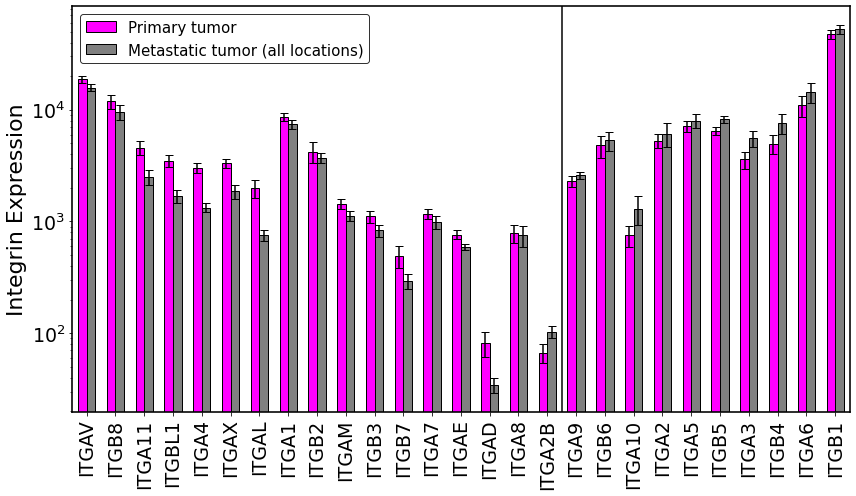

In [287]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
#first the means
primtum_mean = itg_expr_df.primtum_mean.values
met_mean = itg_expr_df.met_mean.values

mean_group=[]

#stdev error bars
primtum_err = itg_expr_df.primtum_sem.values
met_err = itg_expr_df.met_sem.values

x = np.arange(num_items)  # the label locations


width = 0.3  # the width of the bars
margin = 0.2

rects1 = ax.bar(x-width/2,
                primtum_mean, width,yerr=primtum_err, label='Primary tumor',
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

rects2 = ax.bar(x+width/2,
                met_mean, width,yerr=met_err, label='Metastatic tumor (all locations)',
                capsize=4,color='gray',linewidth=1,edgecolor='black')

ax.set_ylabel('Integrin Expression',fontsize=22)
ax.set_yscale('log')
ax.set_xticks(x)

ax.axvline(x=itg_expr_df.index.get_loc(itg_expr_df[(itg_expr_df.relative_expression>0)].iloc[0,:].name)+0.5,
          ymin=0,ymax=1,color='black')

ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


MUST follow proper order in variables
MUST run previous cells in proper order
ITGBL1 -1803.4678449154837
ITGA4 -1682.5609662405932
ITGAX -1461.6991747489628
ITGAL -1248.555112590679


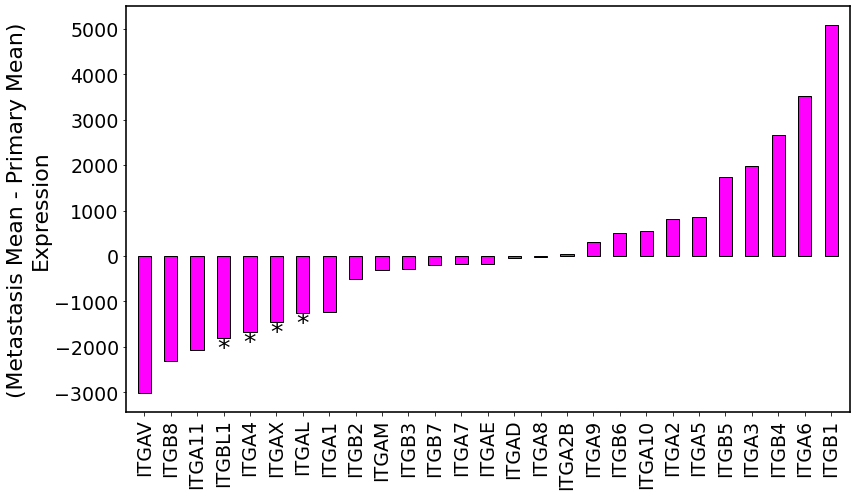

In [310]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,-10), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(Metastasis Mean - Primary Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


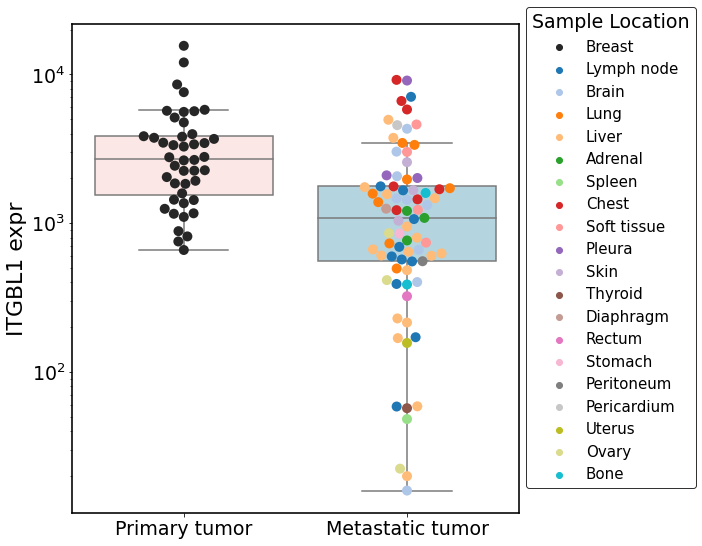

In [107]:
fig,ax=plt.subplots(figsize=(8,9))

gene_chosen='ITGBL1'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='sample_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Primary tumor', 'Metastatic tumor'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Primary tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Metastatic tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

ax.legend( bbox_to_anchor=(1, 1.05),fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)
ax.set_yscale('log')    


/public/apps/python/3.7.0/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 2min 21s, sys: 16.9 s, total: 2min 38s
Wall time: 2min 27s


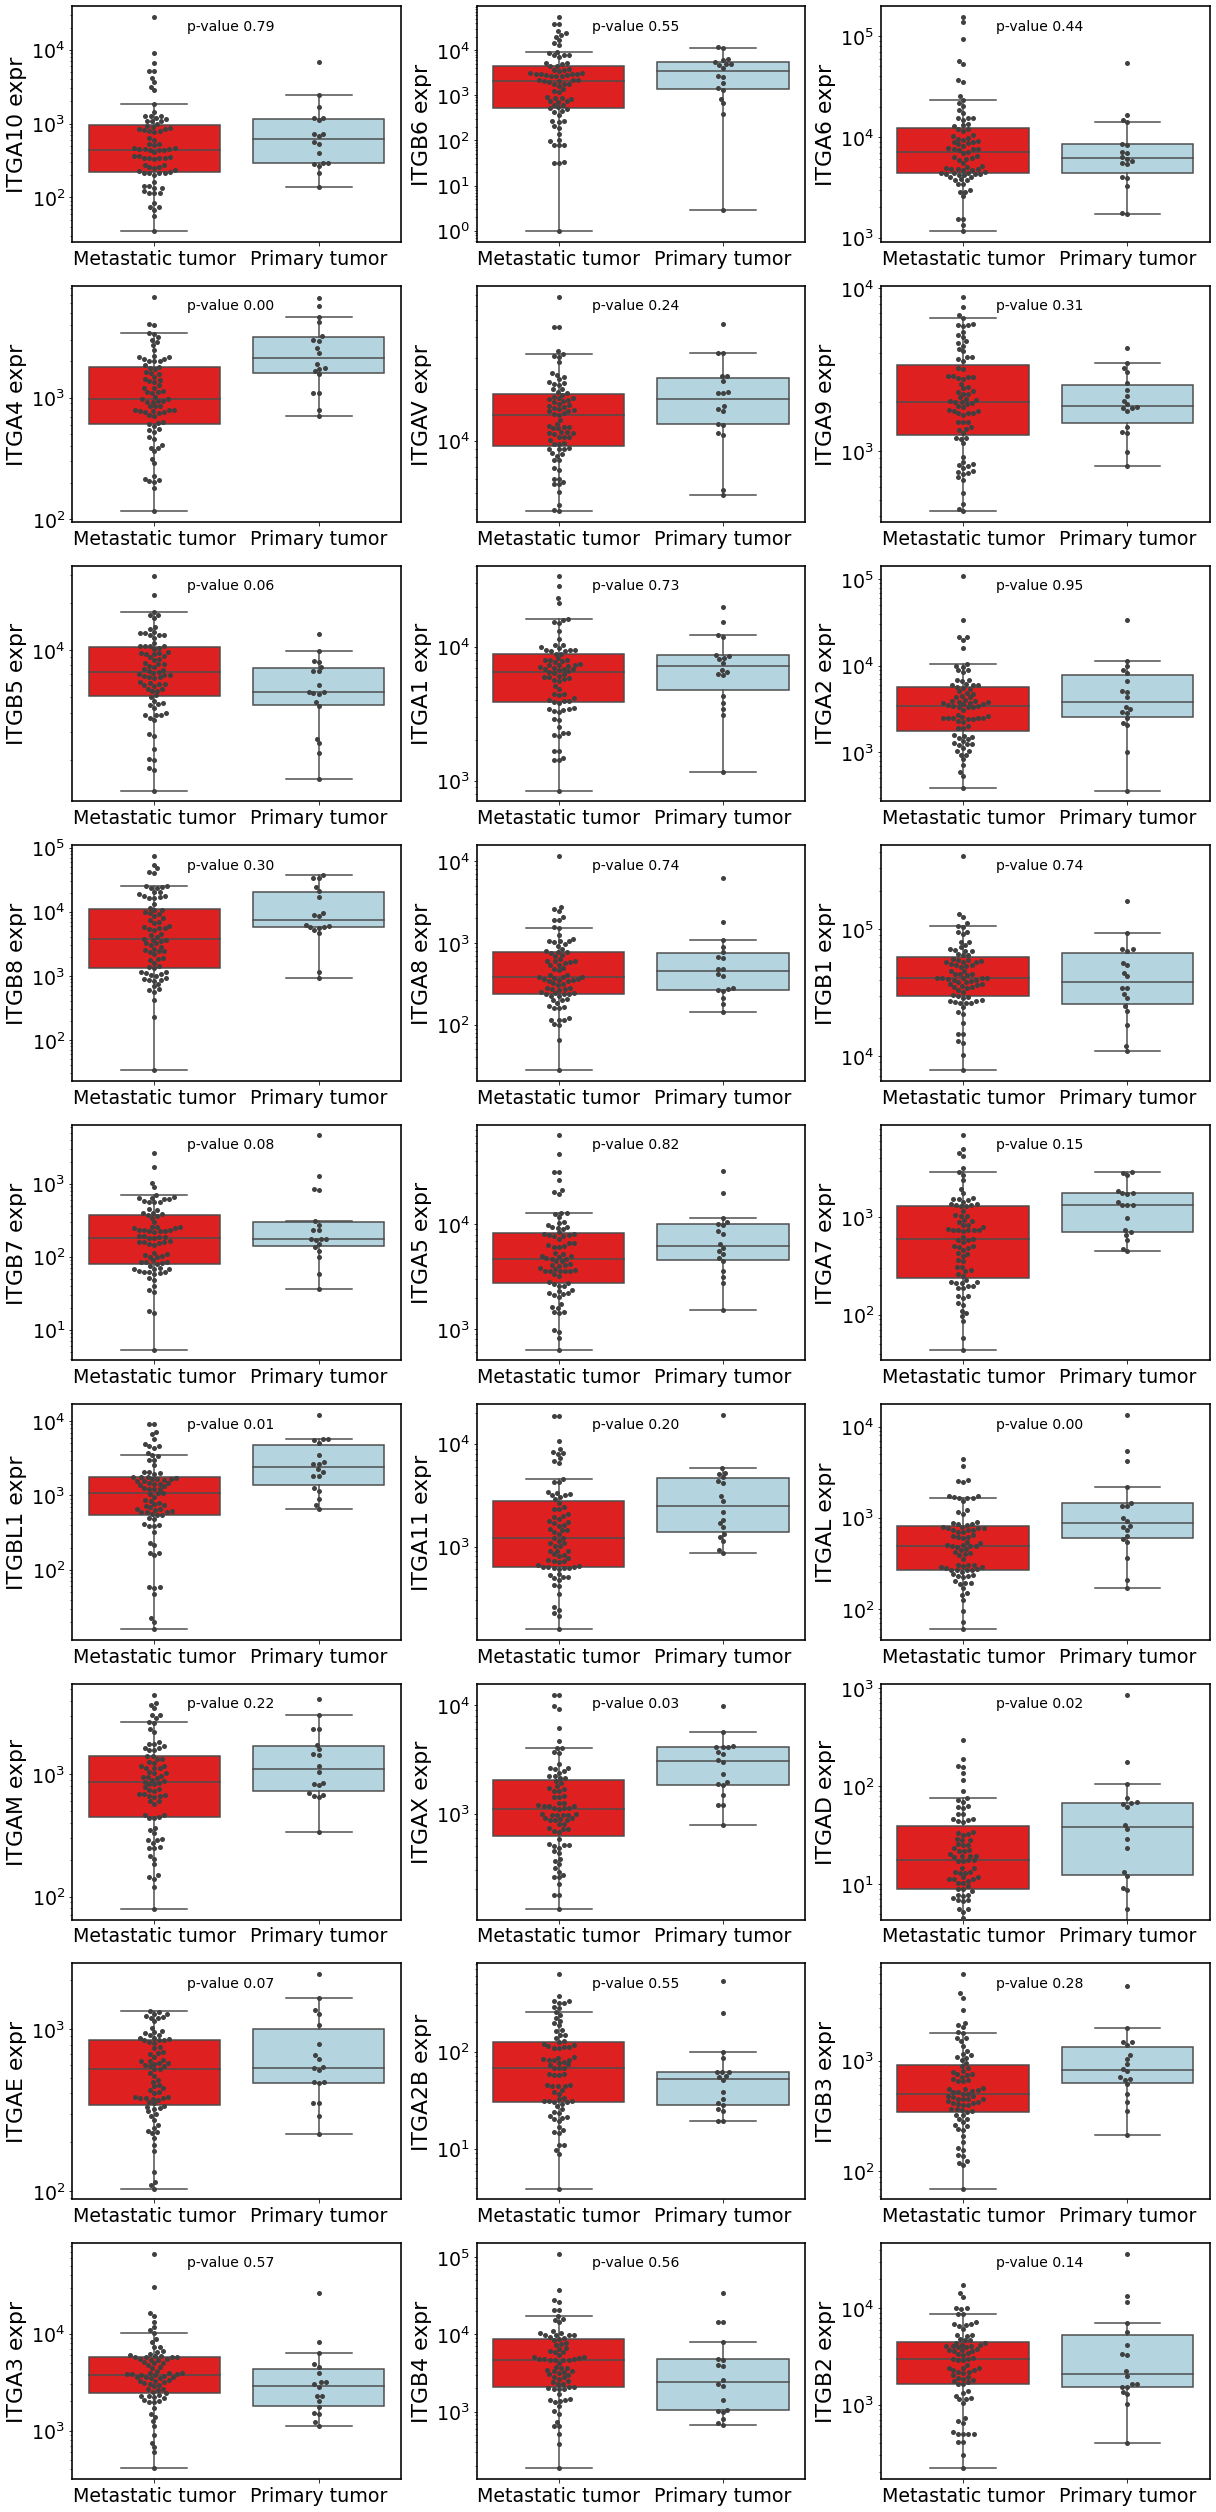

In [36]:
%%time


fig,axs=plt.subplots(nrows=9,ncols=3,figsize=(17,35))

for ax,gene_chosen in zip(axs.ravel(),itg_expr.index.to_list()):
    ax.set_yscale('log')    
    sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='sample_cat',palette=['red','lightblue'],
                          ax=ax,showfliers=False)
    sns.swarmplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='sample_cat',
                          ax=ax,color='.25')

    plt.setp(ax.get_xticklabels(),fontsize=19)
    
    pval_tt=ttest_ind(temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[gene_chosen].values,
                temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[gene_chosen].values).pvalue

    ax.text(0.35,
                   0.9,f'p-value {format(pval_tt,"0.2f")}',
                   transform=ax.transAxes,fontsize=14)
    ax.tick_params(axis='y', labelsize=19)      

    ax.set_ylabel(gene_chosen+' expr',fontsize=22)
    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
    x_axis = ax.axes.get_xaxis()        
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)
    ax.set_yscale('log')    
# axes.minorticks_on()
# axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
# axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   

plt.tight_layout()





In [113]:
del temp_aur_bcm_df, temp_info_sample, primtum_temp_info_sample, met_temp_info_sample

# Primary tumor vs LIVER Metastasis

In [128]:
#separating primary tumor and metastatic tumor
#dropping normal tissue, dropping pre-treatment, since metastasis is post-treatment
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1!='Normal tissue'].copy()
temp_info_sample = temp_info_sample[ temp_info_sample['characteristics_ch1.1.tissue'].isin(['Breast','Liver'])].copy()

#get metastasis data only for patients for whom primary data is available
#get common patients between primary and metastasis
#Use this little chunk if patient-matched samples needed to be used
#common_patid = pd.Index(temp_info_sample[temp_info_sample['source_name_ch1']=='Primary tumor'].patient_id).intersection(temp_info_sample[temp_info_sample['source_name_ch1']=='Metastatic tumor'].patient_id)
#temp_info_sample = temp_info_sample[temp_info_sample['patient_id'].isin(common_patid)]


#now separate primary tumor from metastasis
primtum_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Primary tumor']
met_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Metastatic tumor']

#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [131]:
#add sample category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_cat'] = [met_temp_info_sample['source_name_ch1'].unique()[0] if samid in met_temp_info_sample['sample_id'].values else primtum_temp_info_sample['source_name_ch1'].unique()[0] if samid in primtum_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['sample_cat'].values:
    print('ERROR plz check')

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [132]:
itg_expr_dict={'integrin':[],'primtum_mean':[],'primtum_sem':[],'met_mean':[],
               'met_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['sample_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    primtum_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].mean()
    primtum_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].sem()
    met_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].mean()
    met_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].sem()
    itg_expr_dict['primtum_mean'].append(primtum_sample_expr)
    itg_expr_dict['primtum_sem'].append(primtum_sample_sem)
    itg_expr_dict['met_mean'].append(met_sample_expr)
    itg_expr_dict['met_sem'].append(met_sample_sem)    
    itg_expr_dict['relative_expression'].append(met_sample_expr - primtum_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, primtum_sample_expr, primtum_sample_sem, met_sample_expr, met_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGB8,11872.566372,1718.876596,4137.211171,1255.547199,-7735.355201,0.007904,yes
ITGAV,18765.887089,1459.237618,12864.539106,2293.511472,-5901.347983,0.033521,yes
ITGA11,4581.484843,617.730530,1048.743540,191.406946,-3532.741304,0.000622,yes
ITGBL1,3493.467097,443.254872,1085.896440,307.352382,-2407.570657,0.001489,yes
ITGA4,3012.017835,308.886683,735.745540,137.360460,-2276.272295,0.000021,yes
ITGAX,3317.106195,322.791029,1225.100388,252.422012,-2092.005806,0.000219,yes
ITGB2,4228.297194,874.913860,2419.889898,602.907228,-1808.407296,0.209773,no
ITGAL,1997.958766,366.139935,631.962538,120.377001,-1365.996228,0.021861,yes
ITGA6,10921.540540,2354.984585,9965.112853,3011.507052,-956.427687,0.818972,no


In [133]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df

,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGB8,11872.566372,1718.876596,4137.211171,1255.547199,-7735.355201,0.007904,yes,0.213403,no
ITGAV,18765.887089,1459.237618,12864.539106,2293.511472,-5901.347983,0.033521,yes,0.905060,no
ITGA11,4581.484843,617.730530,1048.743540,191.406946,-3532.741304,0.000622,yes,0.016795,yes
ITGBL1,3493.467097,443.254872,1085.896440,307.352382,-2407.570657,0.001489,yes,0.040206,yes
ITGA4,3012.017835,308.886683,735.745540,137.360460,-2276.272295,0.000021,yes,0.000568,yes
ITGAX,3317.106195,322.791029,1225.100388,252.422012,-2092.005806,0.000219,yes,0.005907,yes
ITGB2,4228.297194,874.913860,2419.889898,602.907228,-1808.407296,0.209773,no,1.000000,no
ITGAL,1997.958766,366.139935,631.962538,120.377001,-1365.996228,0.021861,yes,0.590237,no
ITGA6,10921.540540,2354.984585,9965.112853,3011.507052,-956.427687,0.818972,no,1.000000,no


MUST follow proper order in variables
MUST run previous cells in proper order
ITGA11 -3532.7413035154045
ITGBL1 -2407.5706571640912
ITGA4 -2276.272295271465
ITGAX -2092.005806225756
ITGAM -800.698314837879
ITGA7 -787.1930563835858


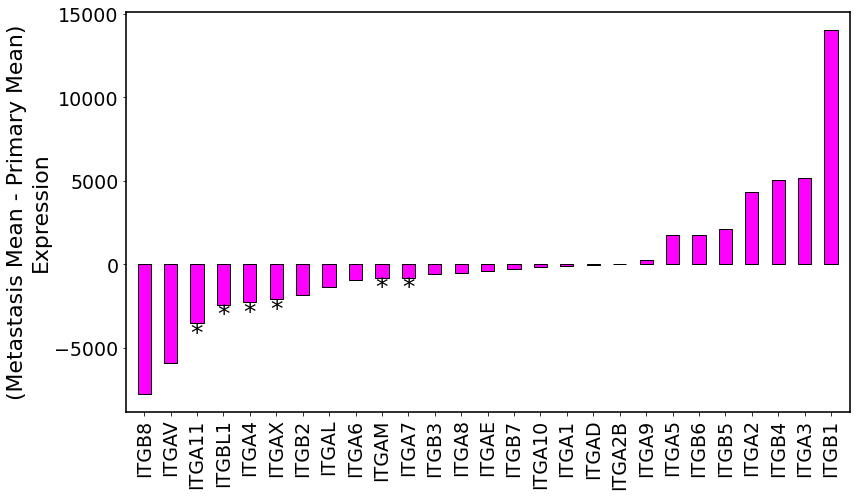

In [134]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,-10), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(Metastasis Mean - Primary Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


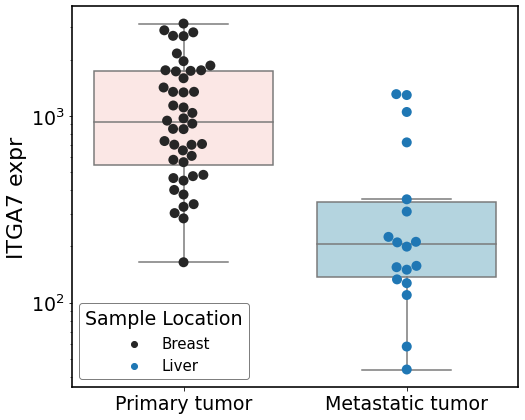

In [151]:
fig,ax=plt.subplots(figsize=(8,7))

gene_chosen='ITGA7'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='sample_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Primary tumor', 'Metastatic tumor'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Primary tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Metastatic tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

legend=ax.legend(fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit',loc='lower left')
legend.get_frame().set_alpha(0.5)
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)
ax.set_yscale('log')    


In [155]:
del temp_info_sample, temp_aur_bcm_df, primtum_temp_info_sample, met_temp_info_sample

# Primary tumor vs Lung Metastasis

In [157]:
#separating primary tumor and metastatic tumor
#dropping normal tissue, dropping pre-treatment, since metastasis is post-treatment
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1!='Normal tissue'].copy()
temp_info_sample = temp_info_sample[ temp_info_sample['characteristics_ch1.1.tissue'].isin(['Breast','Lung'])].copy()

#get metastasis data only for patients for whom primary data is available
#get common patients between primary and metastasis
#Use this little chunk if patient-matched samples needed to be used
#common_patid = pd.Index(temp_info_sample[temp_info_sample['source_name_ch1']=='Primary tumor'].patient_id).intersection(temp_info_sample[temp_info_sample['source_name_ch1']=='Metastatic tumor'].patient_id)
#temp_info_sample = temp_info_sample[temp_info_sample['patient_id'].isin(common_patid)]


#now separate primary tumor from metastasis
primtum_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Primary tumor']
met_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Metastatic tumor']

#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [158]:
#add sample category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_cat'] = [met_temp_info_sample['source_name_ch1'].unique()[0] if samid in met_temp_info_sample['sample_id'].values else primtum_temp_info_sample['source_name_ch1'].unique()[0] if samid in primtum_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['sample_cat'].values:
    print('ERROR plz check')

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [159]:
itg_expr_dict={'integrin':[],'primtum_mean':[],'primtum_sem':[],'met_mean':[],
               'met_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['sample_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    primtum_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].mean()
    primtum_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].sem()
    met_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].mean()
    met_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].sem()
    itg_expr_dict['primtum_mean'].append(primtum_sample_expr)
    itg_expr_dict['primtum_sem'].append(primtum_sample_sem)
    itg_expr_dict['met_mean'].append(met_sample_expr)
    itg_expr_dict['met_sem'].append(met_sample_sem)    
    itg_expr_dict['relative_expression'].append(met_sample_expr - primtum_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, primtum_sample_expr, primtum_sample_sem, met_sample_expr, met_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGAV,18765.887089,1459.237618,13730.871720,1854.647312,-5035.015369,0.160169,no
ITGA11,4581.484843,617.730530,2169.899078,980.666928,-2411.585765,0.117496,no
ITGBL1,3493.467097,443.254872,1836.930516,384.653780,-1656.536581,0.124279,no
ITGA4,3012.017835,308.886683,1555.749251,401.446579,-1456.268585,0.057286,no
ITGAL,1997.958766,366.139935,976.485718,282.915239,-1021.473047,0.247672,no
ITGA7,1166.132906,120.245340,884.511763,302.076246,-281.621143,0.367558,no
ITGA1,8632.486866,746.169691,8439.680074,3050.227544,-192.806792,0.929125,no
ITGAX,3317.106195,322.791029,3156.854113,1122.708265,-160.252082,0.857736,no
ITGB7,492.456273,111.425900,367.216850,196.154812,-125.239422,0.651093,no


In [160]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df

,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGAV,18765.887089,1459.237618,13730.871720,1854.647312,-5035.015369,0.160169,no,1.000000,no
ITGA11,4581.484843,617.730530,2169.899078,980.666928,-2411.585765,0.117496,no,1.000000,no
ITGBL1,3493.467097,443.254872,1836.930516,384.653780,-1656.536581,0.124279,no,1.000000,no
ITGA4,3012.017835,308.886683,1555.749251,401.446579,-1456.268585,0.057286,no,1.000000,no
ITGAL,1997.958766,366.139935,976.485718,282.915239,-1021.473047,0.247672,no,1.000000,no
ITGA7,1166.132906,120.245340,884.511763,302.076246,-281.621143,0.367558,no,1.000000,no
ITGA1,8632.486866,746.169691,8439.680074,3050.227544,-192.806792,0.929125,no,1.000000,no
ITGAX,3317.106195,322.791029,3156.854113,1122.708265,-160.252082,0.857736,no,1.000000,no
ITGB7,492.456273,111.425900,367.216850,196.154812,-125.239422,0.651093,no,1.000000,no


MUST follow proper order in variables
MUST run previous cells in proper order


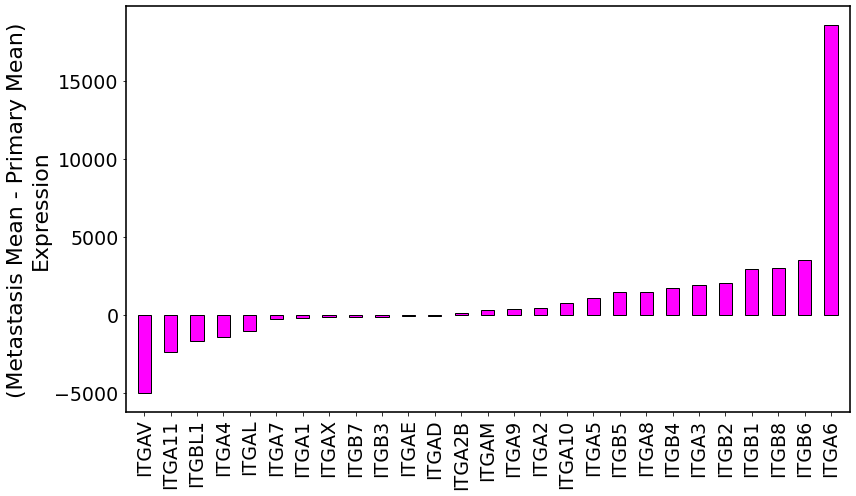

In [161]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,-10), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(Metastasis Mean - Primary Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


/home/hshadman/.local/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 6.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


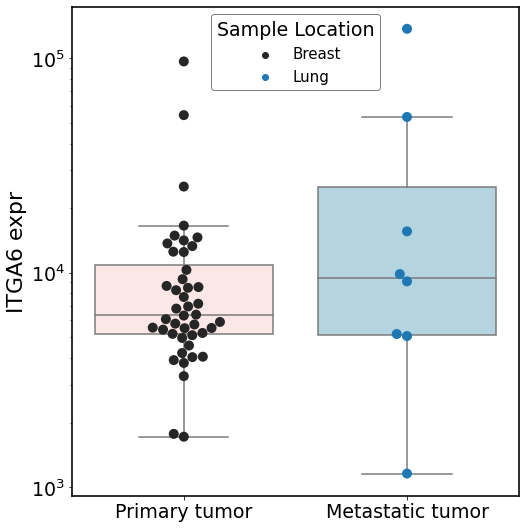

In [164]:
fig,ax=plt.subplots(figsize=(8,9))

gene_chosen='ITGA6'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='sample_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Primary tumor', 'Metastatic tumor'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Primary tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Metastatic tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

legend=ax.legend(fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
legend.get_frame().set_alpha(0.5)
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)
ax.set_yscale('log')    


In [190]:
del temp_info_sample, temp_aur_bcm_df, primtum_temp_info_sample, met_temp_info_sample

# Primary  vs Brain Metastasis

In [199]:
#separating primary tumor and metastatic tumor
#dropping normal tissue, dropping pre-treatment, since metastasis is post-treatment
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1!='Normal tissue'].copy()
temp_info_sample = temp_info_sample[ temp_info_sample['characteristics_ch1.1.tissue'].isin(['Breast','Brain'])].copy()

#get metastasis data only for patients for whom primary data is available
#get common patients between primary and metastasis
#Use this little chunk if patient-matched samples needed to be used
#common_patid = pd.Index(temp_info_sample[temp_info_sample['source_name_ch1']=='Primary tumor'].patient_id).intersection(temp_info_sample[temp_info_sample['source_name_ch1']=='Metastatic tumor'].patient_id)
#temp_info_sample = temp_info_sample[temp_info_sample['patient_id'].isin(common_patid)]


#now separate primary tumor from metastasis
primtum_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Primary tumor']
met_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Metastatic tumor']

#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [200]:
#add sample category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_cat'] = [met_temp_info_sample['source_name_ch1'].unique()[0] if samid in met_temp_info_sample['sample_id'].values else primtum_temp_info_sample['source_name_ch1'].unique()[0] if samid in primtum_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['sample_cat'].values:
    print('ERROR plz check')

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [201]:
itg_expr_dict={'integrin':[],'primtum_mean':[],'primtum_sem':[],'met_mean':[],
               'met_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['sample_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    primtum_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].mean()
    primtum_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].sem()
    met_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].mean()
    met_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].sem()
    itg_expr_dict['primtum_mean'].append(primtum_sample_expr)
    itg_expr_dict['primtum_sem'].append(primtum_sample_sem)
    itg_expr_dict['met_mean'].append(met_sample_expr)
    itg_expr_dict['met_sem'].append(met_sample_sem)    
    itg_expr_dict['relative_expression'].append(met_sample_expr - primtum_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, primtum_sample_expr, primtum_sample_sem, met_sample_expr, met_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGA1,8632.486866,746.169691,4851.715852,773.942117,-3780.771014,0.030264,yes
ITGA11,4581.484843,617.730530,1233.563390,309.151715,-3347.921453,0.019087,yes
ITGAV,18765.887089,1459.237618,15935.959063,2731.374320,-2829.928026,0.417426,no
ITGA5,7122.563112,772.224617,4700.295008,945.266671,-2422.268104,0.176933,no
ITGAX,3317.106195,322.791029,1275.695783,372.810425,-2041.410412,0.007825,yes
ITGA6,10921.540540,2354.984585,9011.457758,1375.948767,-1910.082782,0.719103,no
ITGBL1,3493.467097,443.254872,1634.890838,449.408571,-1858.576259,0.070702,no
ITGA4,3012.017835,308.886683,1192.062406,240.242243,-1819.955429,0.011726,yes
ITGAL,1997.958766,366.139935,682.886246,265.544061,-1315.072520,0.116667,no


In [202]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df

,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGA1,8632.486866,746.169691,4851.715852,773.942117,-3780.771014,0.030264,yes,0.817126,no
ITGA11,4581.484843,617.730530,1233.563390,309.151715,-3347.921453,0.019087,yes,0.515355,no
ITGAV,18765.887089,1459.237618,15935.959063,2731.374320,-2829.928026,0.417426,no,1.000000,no
ITGA5,7122.563112,772.224617,4700.295008,945.266671,-2422.268104,0.176933,no,1.000000,no
ITGAX,3317.106195,322.791029,1275.695783,372.810425,-2041.410412,0.007825,yes,0.211273,no
ITGA6,10921.540540,2354.984585,9011.457758,1375.948767,-1910.082782,0.719103,no,1.000000,no
ITGBL1,3493.467097,443.254872,1634.890838,449.408571,-1858.576259,0.070702,no,1.000000,no
ITGA4,3012.017835,308.886683,1192.062406,240.242243,-1819.955429,0.011726,yes,0.316599,no
ITGAL,1997.958766,366.139935,682.886246,265.544061,-1315.072520,0.116667,no,1.000000,no


MUST follow proper order in variables
MUST run previous cells in proper order


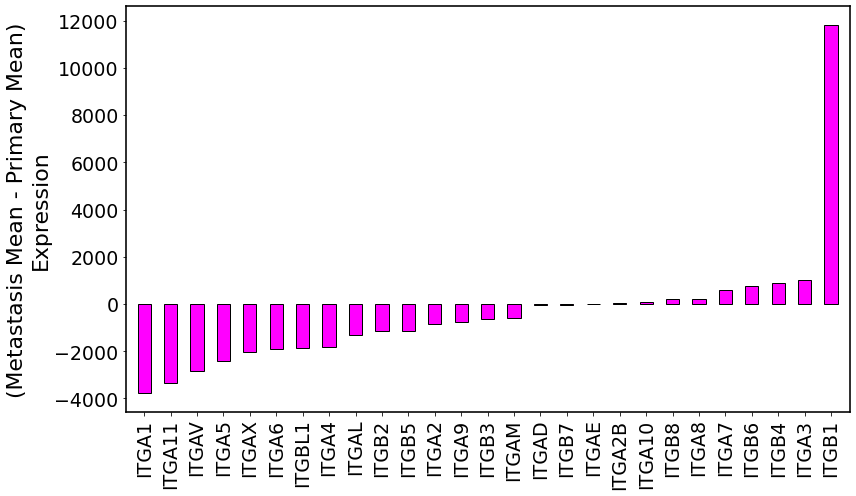

In [203]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,-10), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(Metastasis Mean - Primary Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


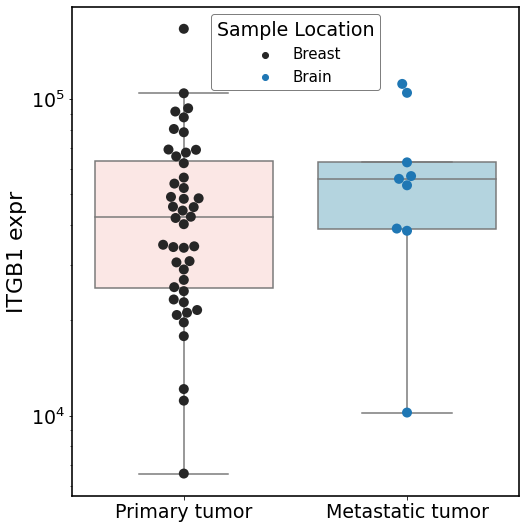

In [204]:
fig,ax=plt.subplots(figsize=(8,9))

gene_chosen='ITGB1'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='sample_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Primary tumor', 'Metastatic tumor'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Primary tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Metastatic tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

legend=ax.legend(fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
legend.get_frame().set_alpha(0.5)
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)
ax.set_yscale('log')    


In [205]:
temp_aur_bcm_df.loc['sample_cat'].value_counts()

Primary tumor       44
Metastatic tumor     9
Name: sample_cat, dtype: int64

In [197]:
del temp_info_sample, temp_aur_bcm_df, primtum_temp_info_sample, met_temp_info_sample

# Primary  vs Lymph node Metastasis

In [179]:
#separating primary tumor and metastatic tumor
#dropping normal tissue, dropping pre-treatment, since metastasis is post-treatment
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1!='Normal tissue'].copy()
temp_info_sample = temp_info_sample[ temp_info_sample['characteristics_ch1.1.tissue'].isin(['Breast','Lymph node'])].copy()

#get metastasis data only for patients for whom primary data is available
#get common patients between primary and metastasis
#Use this little chunk if patient-matched samples needed to be used
#common_patid = pd.Index(temp_info_sample[temp_info_sample['source_name_ch1']=='Primary tumor'].patient_id).intersection(temp_info_sample[temp_info_sample['source_name_ch1']=='Metastatic tumor'].patient_id)
#temp_info_sample = temp_info_sample[temp_info_sample['patient_id'].isin(common_patid)]


#now separate primary tumor from metastasis
primtum_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Primary tumor']
met_temp_info_sample = temp_info_sample[temp_info_sample.source_name_ch1=='Metastatic tumor']

#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [180]:
#add sample category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_cat'] = [met_temp_info_sample['source_name_ch1'].unique()[0] if samid in met_temp_info_sample['sample_id'].values else primtum_temp_info_sample['source_name_ch1'].unique()[0] if samid in primtum_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['sample_cat'].values:
    print('ERROR plz check')

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

In [181]:
itg_expr_dict={'integrin':[],'primtum_mean':[],'primtum_sem':[],'met_mean':[],
               'met_sem':[],
               'relative_expression':[],'p_value':[],'significant':[]}
p_value_cutoff=0.05
for itg in temp_aur_bcm_df.loc[~temp_aur_bcm_df.index.isin(['sample_cat','sample_loc'])].loc[itg_expr.index].index:
    itg_expr_dict['integrin'].append(itg)
    primtum_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].mean()
    primtum_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].sem()
    met_sample_expr=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].mean()
    met_sample_sem=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].sem()
    itg_expr_dict['primtum_mean'].append(primtum_sample_expr)
    itg_expr_dict['primtum_sem'].append(primtum_sample_sem)
    itg_expr_dict['met_mean'].append(met_sample_expr)
    itg_expr_dict['met_sem'].append(met_sample_sem)    
    itg_expr_dict['relative_expression'].append(met_sample_expr - primtum_sample_expr)
    p_value_itg=stats.ttest_ind(a=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Primary tumor'].loc[itg].values,
                                                    b=temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['sample_cat']=='Metastatic tumor'].loc[itg].values).pvalue
    itg_expr_dict['p_value'].append(p_value_itg) 
    if p_value_itg>=p_value_cutoff:
        itg_expr_dict['significant'].append('no')
    else:
        itg_expr_dict['significant'].append('yes')
        
itg_expr_df=pd.DataFrame(itg_expr_dict).set_index('integrin')
del itg_expr_dict, primtum_sample_expr, primtum_sample_sem, met_sample_expr, met_sample_sem

itg_expr_df = itg_expr_df.sort_values(by='relative_expression')
itg_expr_df


,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant
integrin,,,,,,,
ITGB6,4799.788235,1067.742782,2241.230899,686.635008,-2558.557336,0.244978,no
ITGA11,4581.484843,617.730530,2212.938345,576.537087,-2368.546498,0.068834,no
ITGBL1,3493.467097,443.254872,1326.885797,597.654537,-2166.581300,0.024937,yes
ITGA1,8632.486866,746.169691,7049.940695,1090.538771,-1582.546171,0.325146,no
ITGAV,18765.887089,1459.237618,17226.808777,3440.930074,-1539.078313,0.650805,no
ITGA4,3012.017835,308.886683,2147.815690,552.556025,-864.202146,0.207691,no
ITGAL,1997.958766,366.139935,1331.831281,446.313615,-666.127484,0.390049,no
ITGA5,7122.563112,772.224617,6543.215922,1562.775497,-579.347190,0.739127,no
ITGB3,1110.668940,138.429813,618.211910,157.587121,-492.457030,0.094375,no


In [182]:
#now going to do multiple testing correction (careful must be run once after running previous cell)
pvals=itg_expr_df.p_value.values
#trying , calculuating p values and corresponding sig
itg_expr_df['adj_p_val_bonf']=multi.multipletests(pvals, alpha=0.05, method='bonferroni', is_sorted=False, returnsorted=False)[1]
itg_expr_df['adj_significant_bonf']=['yes' if p_value<p_value_cutoff else 'no' for p_value in itg_expr_df['adj_p_val_bonf'].values ]

itg_expr_df

,primtum_mean,primtum_sem,met_mean,met_sem,relative_expression,p_value,significant,adj_p_val_bonf,adj_significant_bonf
integrin,,,,,,,,,
ITGB6,4799.788235,1067.742782,2241.230899,686.635008,-2558.557336,0.244978,no,1.000000,no
ITGA11,4581.484843,617.730530,2212.938345,576.537087,-2368.546498,0.068834,no,1.000000,no
ITGBL1,3493.467097,443.254872,1326.885797,597.654537,-2166.581300,0.024937,yes,0.673291,no
ITGA1,8632.486866,746.169691,7049.940695,1090.538771,-1582.546171,0.325146,no,1.000000,no
ITGAV,18765.887089,1459.237618,17226.808777,3440.930074,-1539.078313,0.650805,no,1.000000,no
ITGA4,3012.017835,308.886683,2147.815690,552.556025,-864.202146,0.207691,no,1.000000,no
ITGAL,1997.958766,366.139935,1331.831281,446.313615,-666.127484,0.390049,no,1.000000,no
ITGA5,7122.563112,772.224617,6543.215922,1562.775497,-579.347190,0.739127,no,1.000000,no
ITGB3,1110.668940,138.429813,618.211910,157.587121,-492.457030,0.094375,no,1.000000,no


MUST follow proper order in variables
MUST run previous cells in proper order


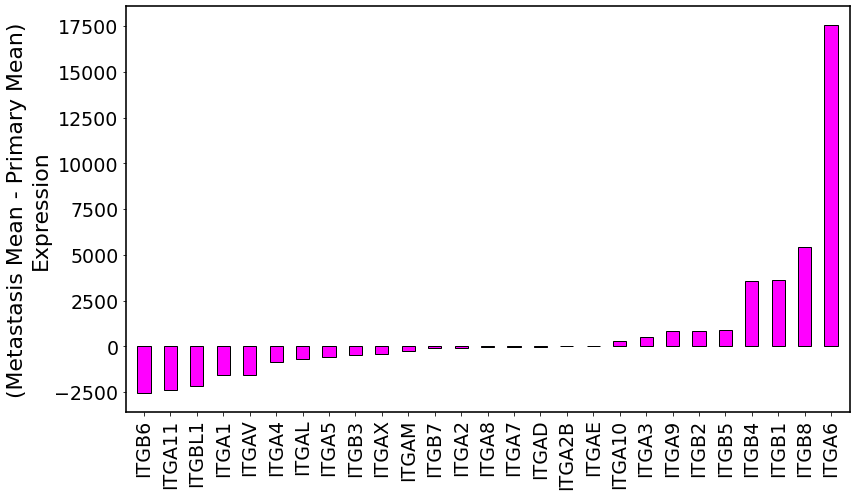

In [185]:
print('MUST follow proper order in variables\nMUST run previous cells in proper order')
fig, ax = plt.subplots(figsize=(12,7))
labels = itg_expr_df.index.to_list()
num_items = len(labels)
width = 0.5  # the width of the bars
margin = 0.2
x = np.arange(num_items)  # the label locations

rects1 = ax.bar(x,
                itg_expr_df.relative_expression.values, width,
                capsize=4,color='magenta',linewidth=1,edgecolor='black')

for bar,integrin in zip(rects1.patches,labels):
    if itg_expr_df.loc[integrin]['adj_significant_bonf']=='yes':
        print(integrin,bar.get_height())
        ax.annotate('*',
                   (bar.get_x() + bar.get_width()/2,
                    bar.get_height()),xytext=(0,-10), ha='center', va='center',
                   size=25,textcoords='offset points')


ax.set_ylabel('(Metastasis Mean - Primary Mean)\nExpression',fontsize=22)

ax.set_xticks(x)


ax.set_xlim(x.min()-width-margin,x.max()+width+margin)
ax.set_xticklabels(labels,fontsize=19,rotation=90)
plt.setp(ax.get_yticklabels(),fontsize=19)

#ax.legend(fontsize=15,edgecolor ='inherit')

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
        
fig.tight_layout()
#fig.savefig('figures_for_publication/all_secstruc.png',dpi=400,bbox_inches='tight')


/home/hshadman/.local/lib/python3.7/site-packages/seaborn/categorical.py:3543: UserWarning: 11.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


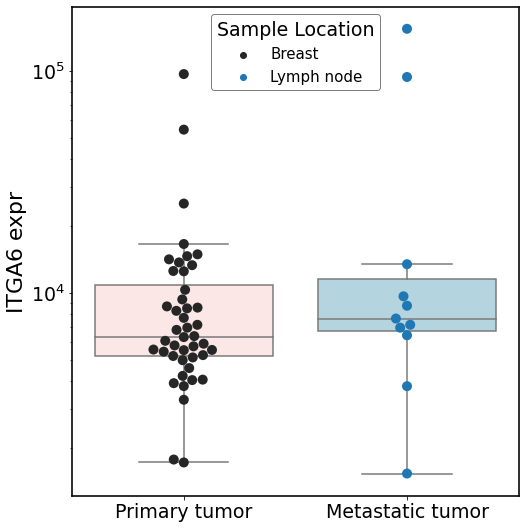

In [186]:
fig,ax=plt.subplots(figsize=(8,9))

gene_chosen='ITGA6'

sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
               x='sample_cat',palette=['mistyrose','lightblue'],
                      ax=ax,showfliers=False,order = ['Primary tumor', 'Metastatic tumor'])

sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Primary tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='dark:black',
                      ax=ax,size=10)


sns.swarmplot(data=temp_aur_bcm_df.T[temp_aur_bcm_df.T['sample_cat']=='Metastatic tumor'],y=gene_chosen,
               x='sample_cat',hue='sample_loc',palette='tab20',
                      ax=ax,size=10,marker='o')

legend=ax.legend(fontsize=15,title='Sample Location',
                title_fontsize=19,edgecolor='inherit')
legend.get_frame().set_alpha(0.5)
plt.setp(ax.get_xticklabels(),fontsize=19)
ax.tick_params(axis='y', labelsize=19)      

ax.set_ylabel(gene_chosen+' expr',fontsize=22)
for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
x_axis = ax.axes.get_xaxis()        
x_label = x_axis.get_label()
##print isinstance(x_label, matplotlib.artist.Artist)
x_label.set_visible(False)
ax.set_yscale('log')    


In [187]:
del temp_info_sample, temp_aur_bcm_df, primtum_temp_info_sample, met_temp_info_sample

# Primary tumor Pre-treatment vs Post-treatment

In [57]:
# just using primary tumor since for only primary tumor we have pre and post treatment
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1=='Primary tumor'].copy()
#drop unknown FROM temp_info_sample
temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.3.treatment']!='Unknown'].copy()


#now separate post and pre
pre_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.3.treatment']=='Pre-treatment']
post_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.3.treatment']=='Post-treatment']


#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [ ]:
# add treatment category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['treat_cat'] = [post_temp_info_sample['characteristics_ch1.3.treatment'].unique()[0] if samid in post_temp_info_sample['sample_id'].values else pre_temp_info_sample['characteristics_ch1.3.treatment'].unique()[0] if samid in pre_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['treat_cat'].values:
    print('ERROR plz check')
elif post_temp_info_sample['characteristics_ch1.3.treatment'].unique().shape[0]>1 or pre_temp_info_sample['characteristics_ch1.3.treatment'].unique().shape[0]>1:
    print('ERROR plz check')    

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

CPU times: user 2min 10s, sys: 14.4 s, total: 2min 24s
Wall time: 2min 14s


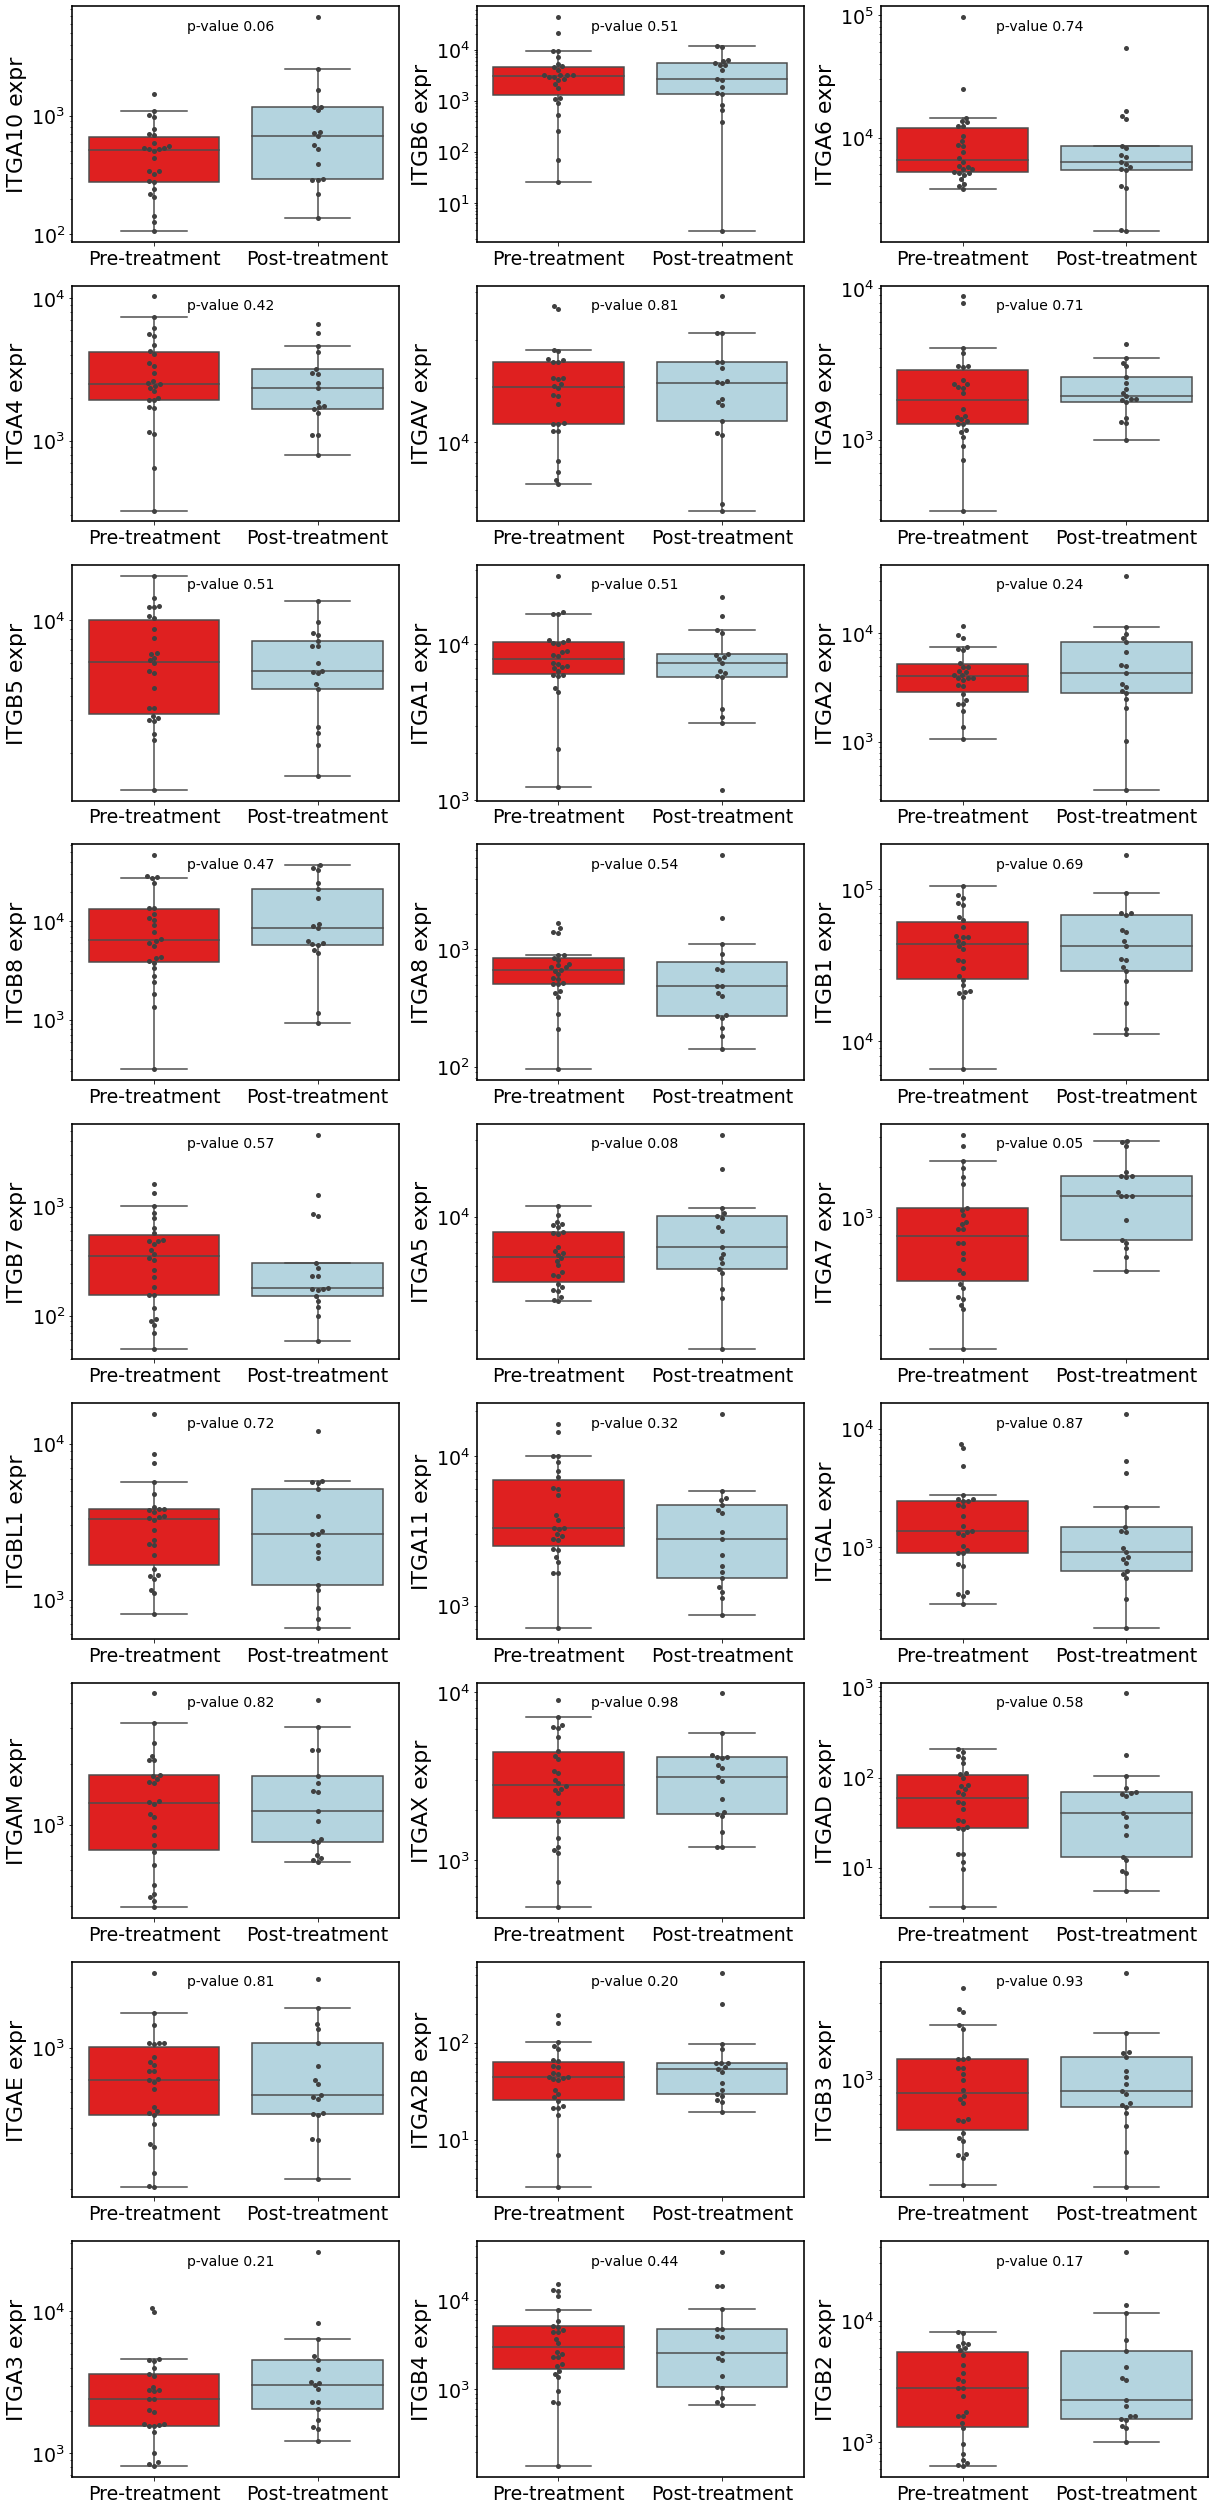

In [75]:
%%time


fig,axs=plt.subplots(nrows=9,ncols=3,figsize=(17,35))

for ax,gene_chosen in zip(axs.ravel(),itg_expr.index.to_list()):
    ax.set_yscale('log')    
    sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='treat_cat',palette=['red','lightblue'],
                          ax=ax,showfliers=False)
    sns.swarmplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='treat_cat',
                          ax=ax,color='.25')

    plt.setp(ax.get_xticklabels(),fontsize=19)
    
    pval_tt=ttest_ind(temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['treat_cat']=='Post-treatment'].loc[gene_chosen].values,
                temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['treat_cat']=='Pre-treatment'].loc[gene_chosen].values).pvalue

    ax.text(0.35,
                   0.9,f'p-value {format(pval_tt,"0.2f")}',
                   transform=ax.transAxes,fontsize=14)
    ax.tick_params(axis='y', labelsize=19)      

    ax.set_ylabel(gene_chosen+' expr',fontsize=22)
    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
    x_axis = ax.axes.get_xaxis()        
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)
    ax.set_yscale('log')    
# axes.minorticks_on()
# axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
# axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   

plt.tight_layout()





In [78]:
del temp_aur_bcm_df, temp_info_sample, pre_temp_info_sample, post_temp_info_sample


# Just metastatic samples, comparing liver vs non-liver

In [95]:
# just using met tumor 
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1=='Metastatic tumor'].copy()


#now separate liver and nonliver
liver_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Liver']
nonliver_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']!='Liver']


#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [98]:
#add metastasis category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['met_cat'] = ['non-liver' if samid in nonliver_temp_info_sample['sample_id'].values else liver_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in liver_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['met_cat'].values:
    print('ERROR plz check')
# elif nonliver_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1 or liver_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1:
#     print('ERROR plz check')    

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

/public/apps/python/3.7.0/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 2min 14s, sys: 14.4 s, total: 2min 28s
Wall time: 2min 17s


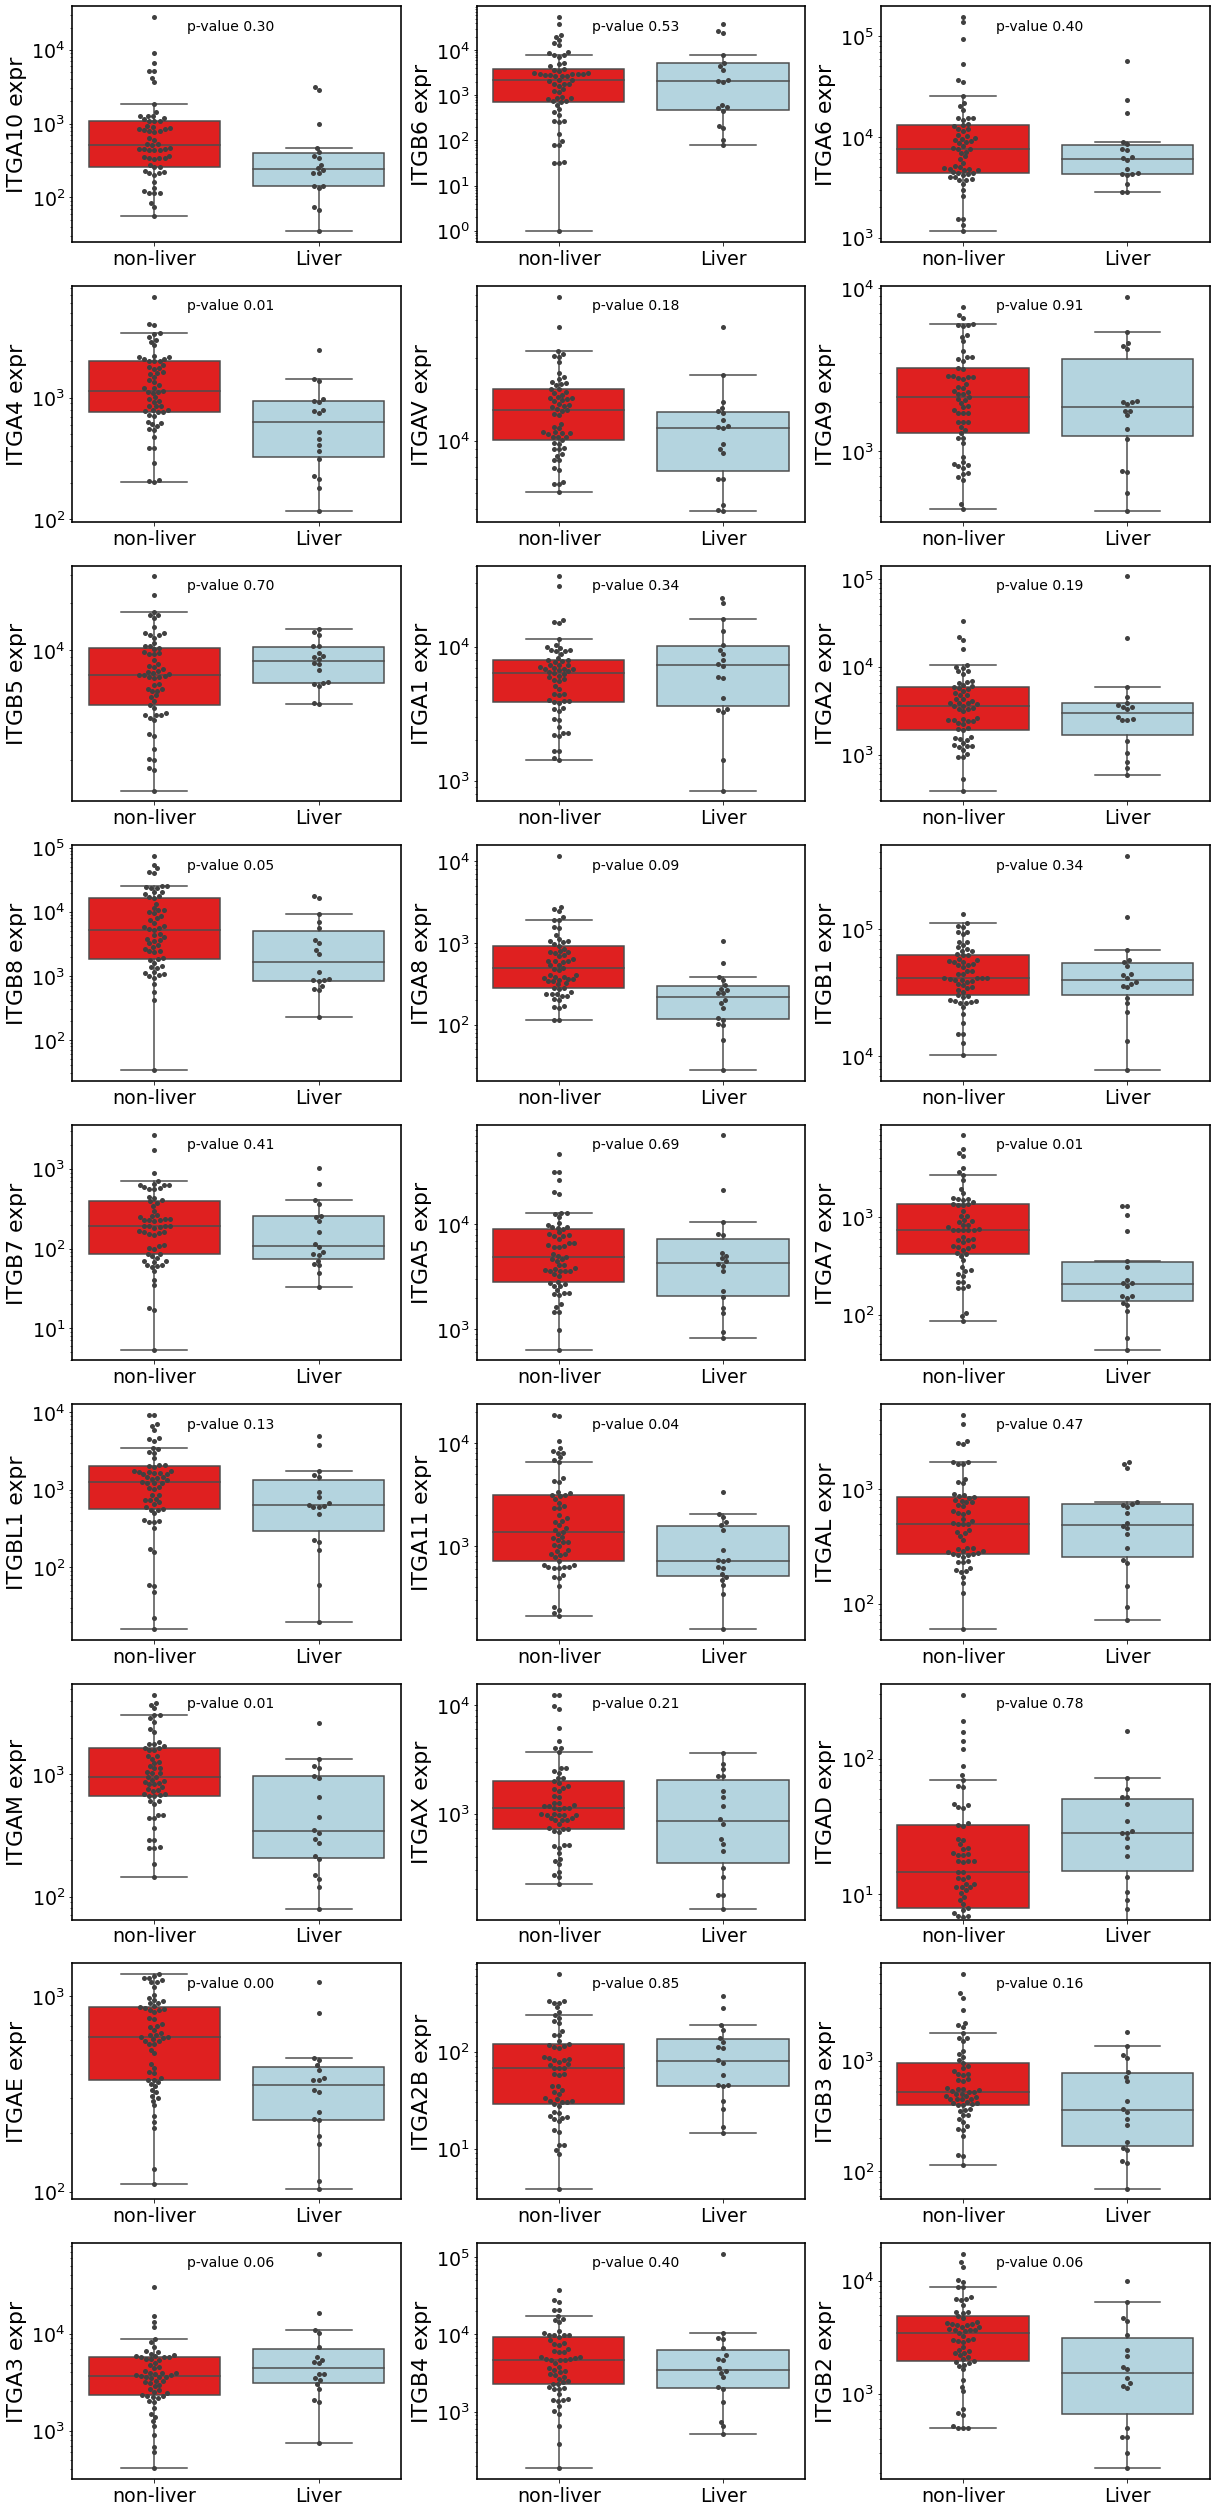

In [106]:
%%time


fig,axs=plt.subplots(nrows=9,ncols=3,figsize=(17,35))

for ax,gene_chosen in zip(axs.ravel(),itg_expr.index.to_list()):
    ax.set_yscale('log')    
    sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='met_cat',palette=['red','lightblue'],
                          ax=ax,showfliers=False)
    sns.swarmplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='met_cat',
                          ax=ax,color='.25')

    plt.setp(ax.get_xticklabels(),fontsize=19)
    
    pval_tt=ttest_ind(temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='non-liver'].loc[gene_chosen].values,
                temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Liver'].loc[gene_chosen].values).pvalue

    ax.text(0.35,
                   0.9,f'p-value {format(pval_tt,"0.2f")}',
                   transform=ax.transAxes,fontsize=14)
    ax.tick_params(axis='y', labelsize=19)      

    ax.set_ylabel(gene_chosen+' expr',fontsize=22)
    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
    x_axis = ax.axes.get_xaxis()        
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)
    ax.set_yscale('log')    
# axes.minorticks_on()
# axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
# axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   

plt.tight_layout()





In [109]:
del temp_info_sample, temp_aur_bcm_df,liver_temp_info_sample, nonliver_temp_info_sample

NameError: name 'liver_temp_info_sample' is not defined

# for metastatic samples, compare brain vs non-brain

In [108]:
# just using met tumor 
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1=='Metastatic tumor'].copy()


#now separate liver and nonliver
brain_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Brain']
nonbrain_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']!='Brain']


#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [109]:
#add metastasis category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['met_cat'] = ['non-brain' if samid in nonbrain_temp_info_sample['sample_id'].values else brain_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in brain_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['met_cat'].values:
    print('ERROR plz check')
# elif nonliver_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1 or liver_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1:
#     print('ERROR plz check')    

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

/public/apps/python/3.7.0/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 2min 17s, sys: 15.2 s, total: 2min 32s
Wall time: 2min 21s


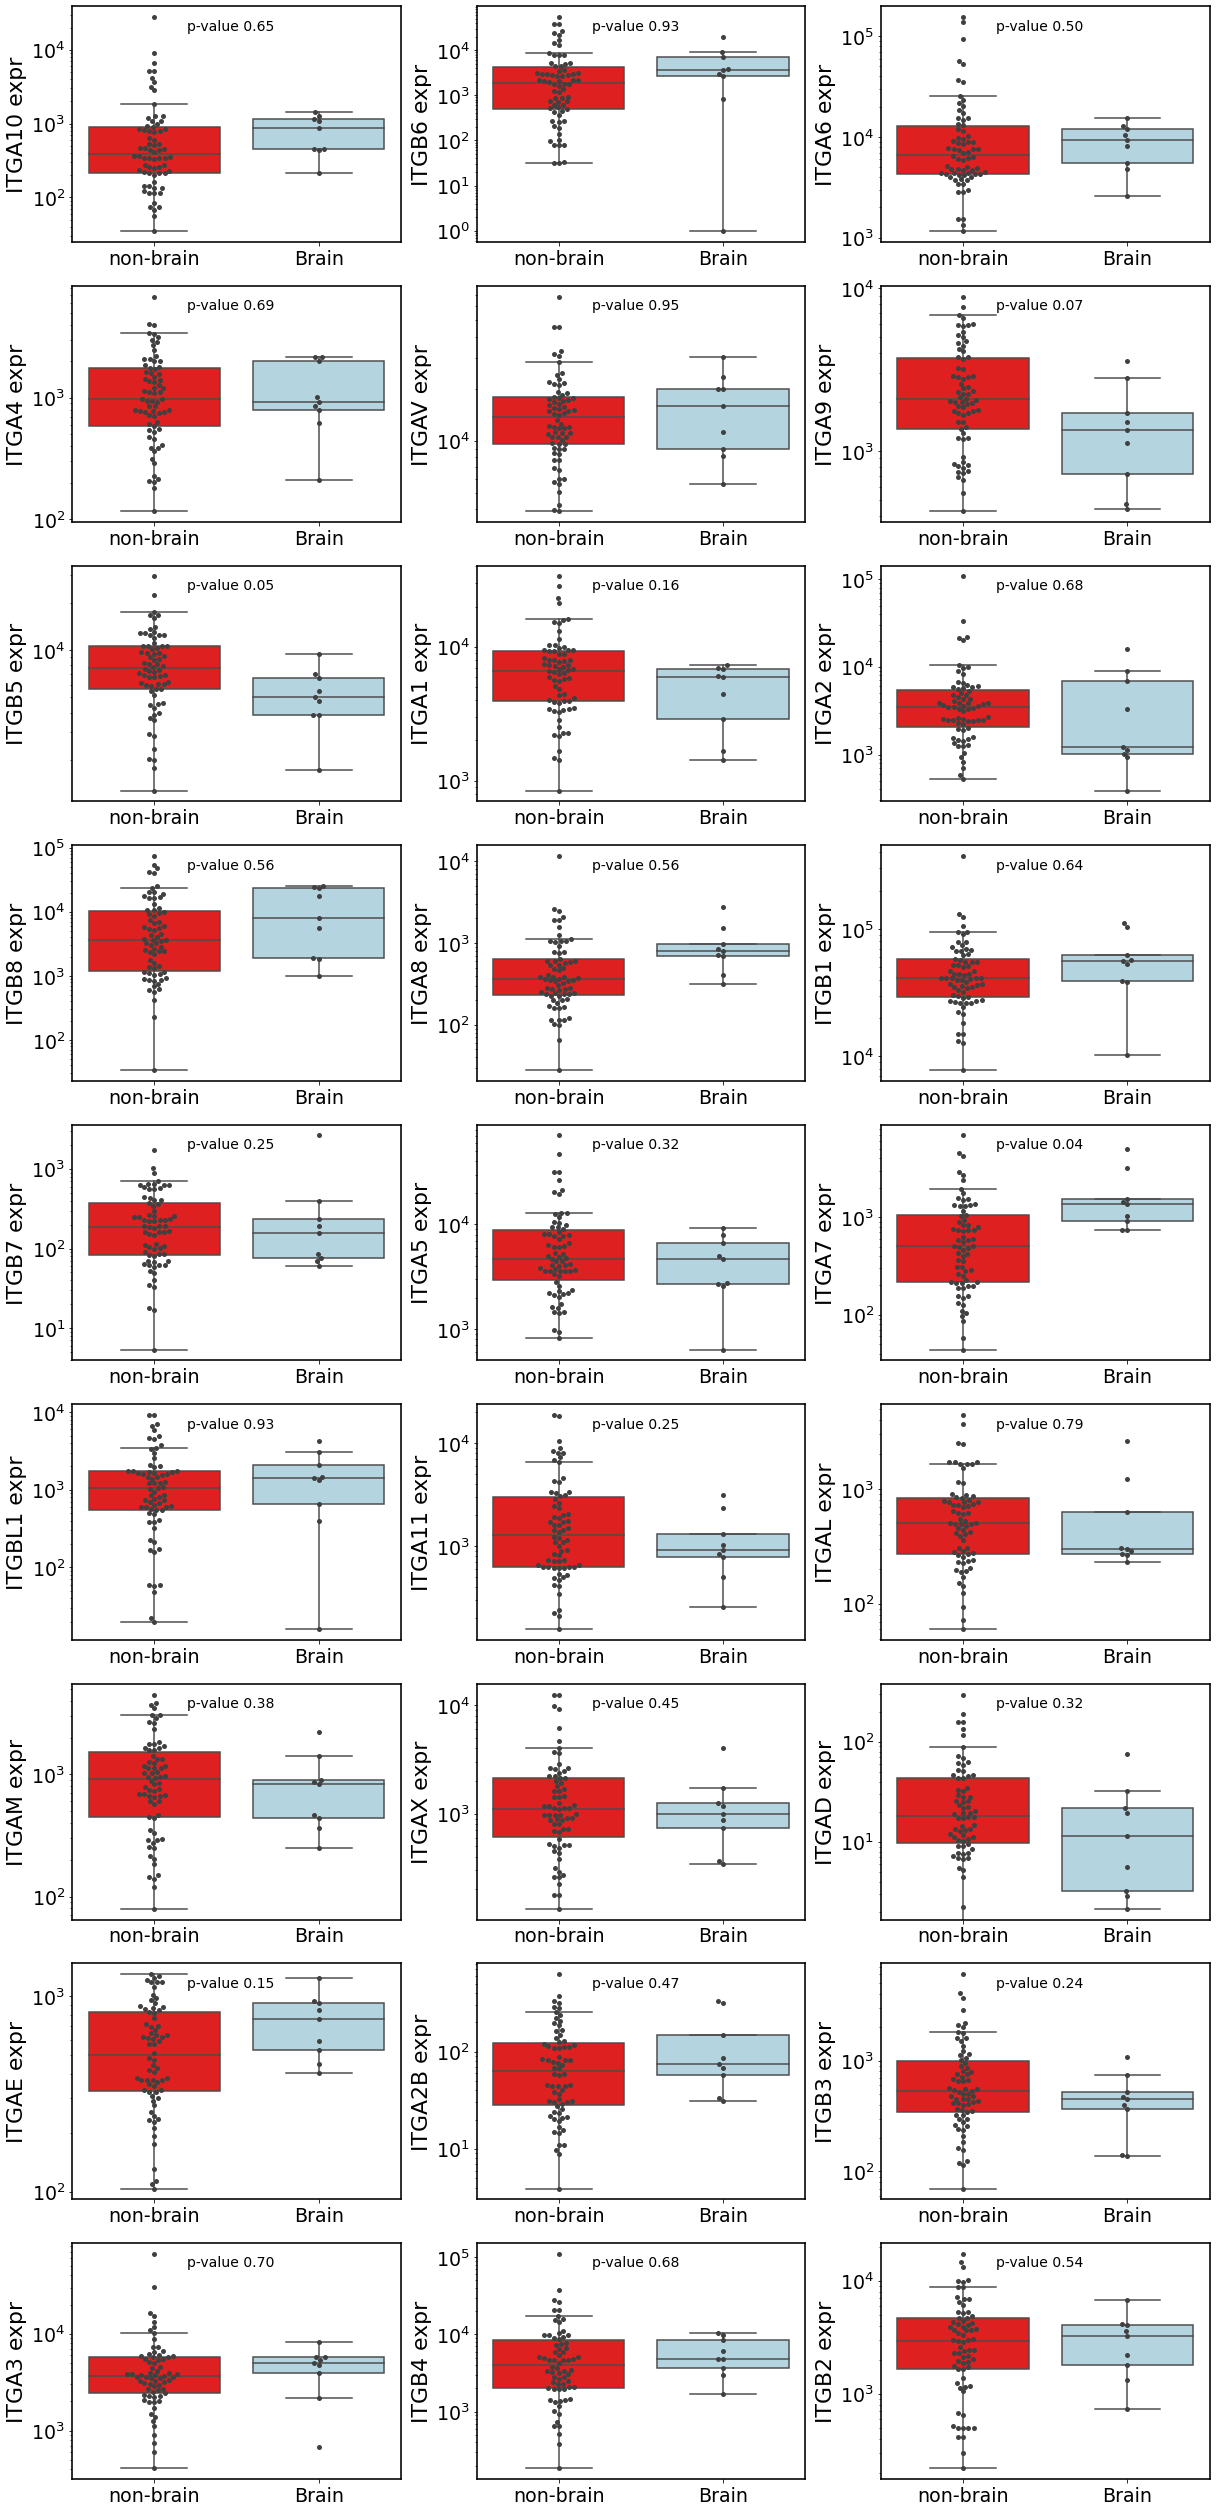

In [110]:
%%time


fig,axs=plt.subplots(nrows=9,ncols=3,figsize=(17,35))

for ax,gene_chosen in zip(axs.ravel(),itg_expr.index.to_list()):
    ax.set_yscale('log')    
    sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='met_cat',palette=['red','lightblue'],
                          ax=ax,showfliers=False)
    sns.swarmplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='met_cat',
                          ax=ax,color='.25')

    plt.setp(ax.get_xticklabels(),fontsize=19)
    
    pval_tt=ttest_ind(temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='non-brain'].loc[gene_chosen].values,
                temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Brain'].loc[gene_chosen].values).pvalue

    ax.text(0.35,
                   0.9,f'p-value {format(pval_tt,"0.2f")}',
                   transform=ax.transAxes,fontsize=14)
    ax.tick_params(axis='y', labelsize=19)      

    ax.set_ylabel(gene_chosen+' expr',fontsize=22)
    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
    x_axis = ax.axes.get_xaxis()        
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)
    ax.set_yscale('log')    
# axes.minorticks_on()
# axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
# axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   

plt.tight_layout()





In [115]:
del temp_aur_bcm_df, temp_info_sample, brain_temp_info_sample, nonbrain_temp_info_sample

# for metastatic samples, compare liver vs lymph node

In [129]:
# just using met tumor 
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1=='Metastatic tumor'].copy()
temp_info_sample = temp_info_sample[(temp_info_sample['characteristics_ch1.1.tissue']=='Liver') | (temp_info_sample['characteristics_ch1.1.tissue']=='Lymph node')]

#now separate liver and nonliver
liver_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Liver']
lymphnode_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Lymph node']


#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [130]:
#add metastasis category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['met_cat'] = [liver_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in liver_temp_info_sample['sample_id'].values else lymphnode_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in lymphnode_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['met_cat'].values:
    print('ERROR plz check1')
elif liver_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1 or lymphnode_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1:
    print('ERROR plz check2')    

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

/public/apps/python/3.7.0/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 2min 5s, sys: 11.8 s, total: 2min 17s
Wall time: 2min 7s


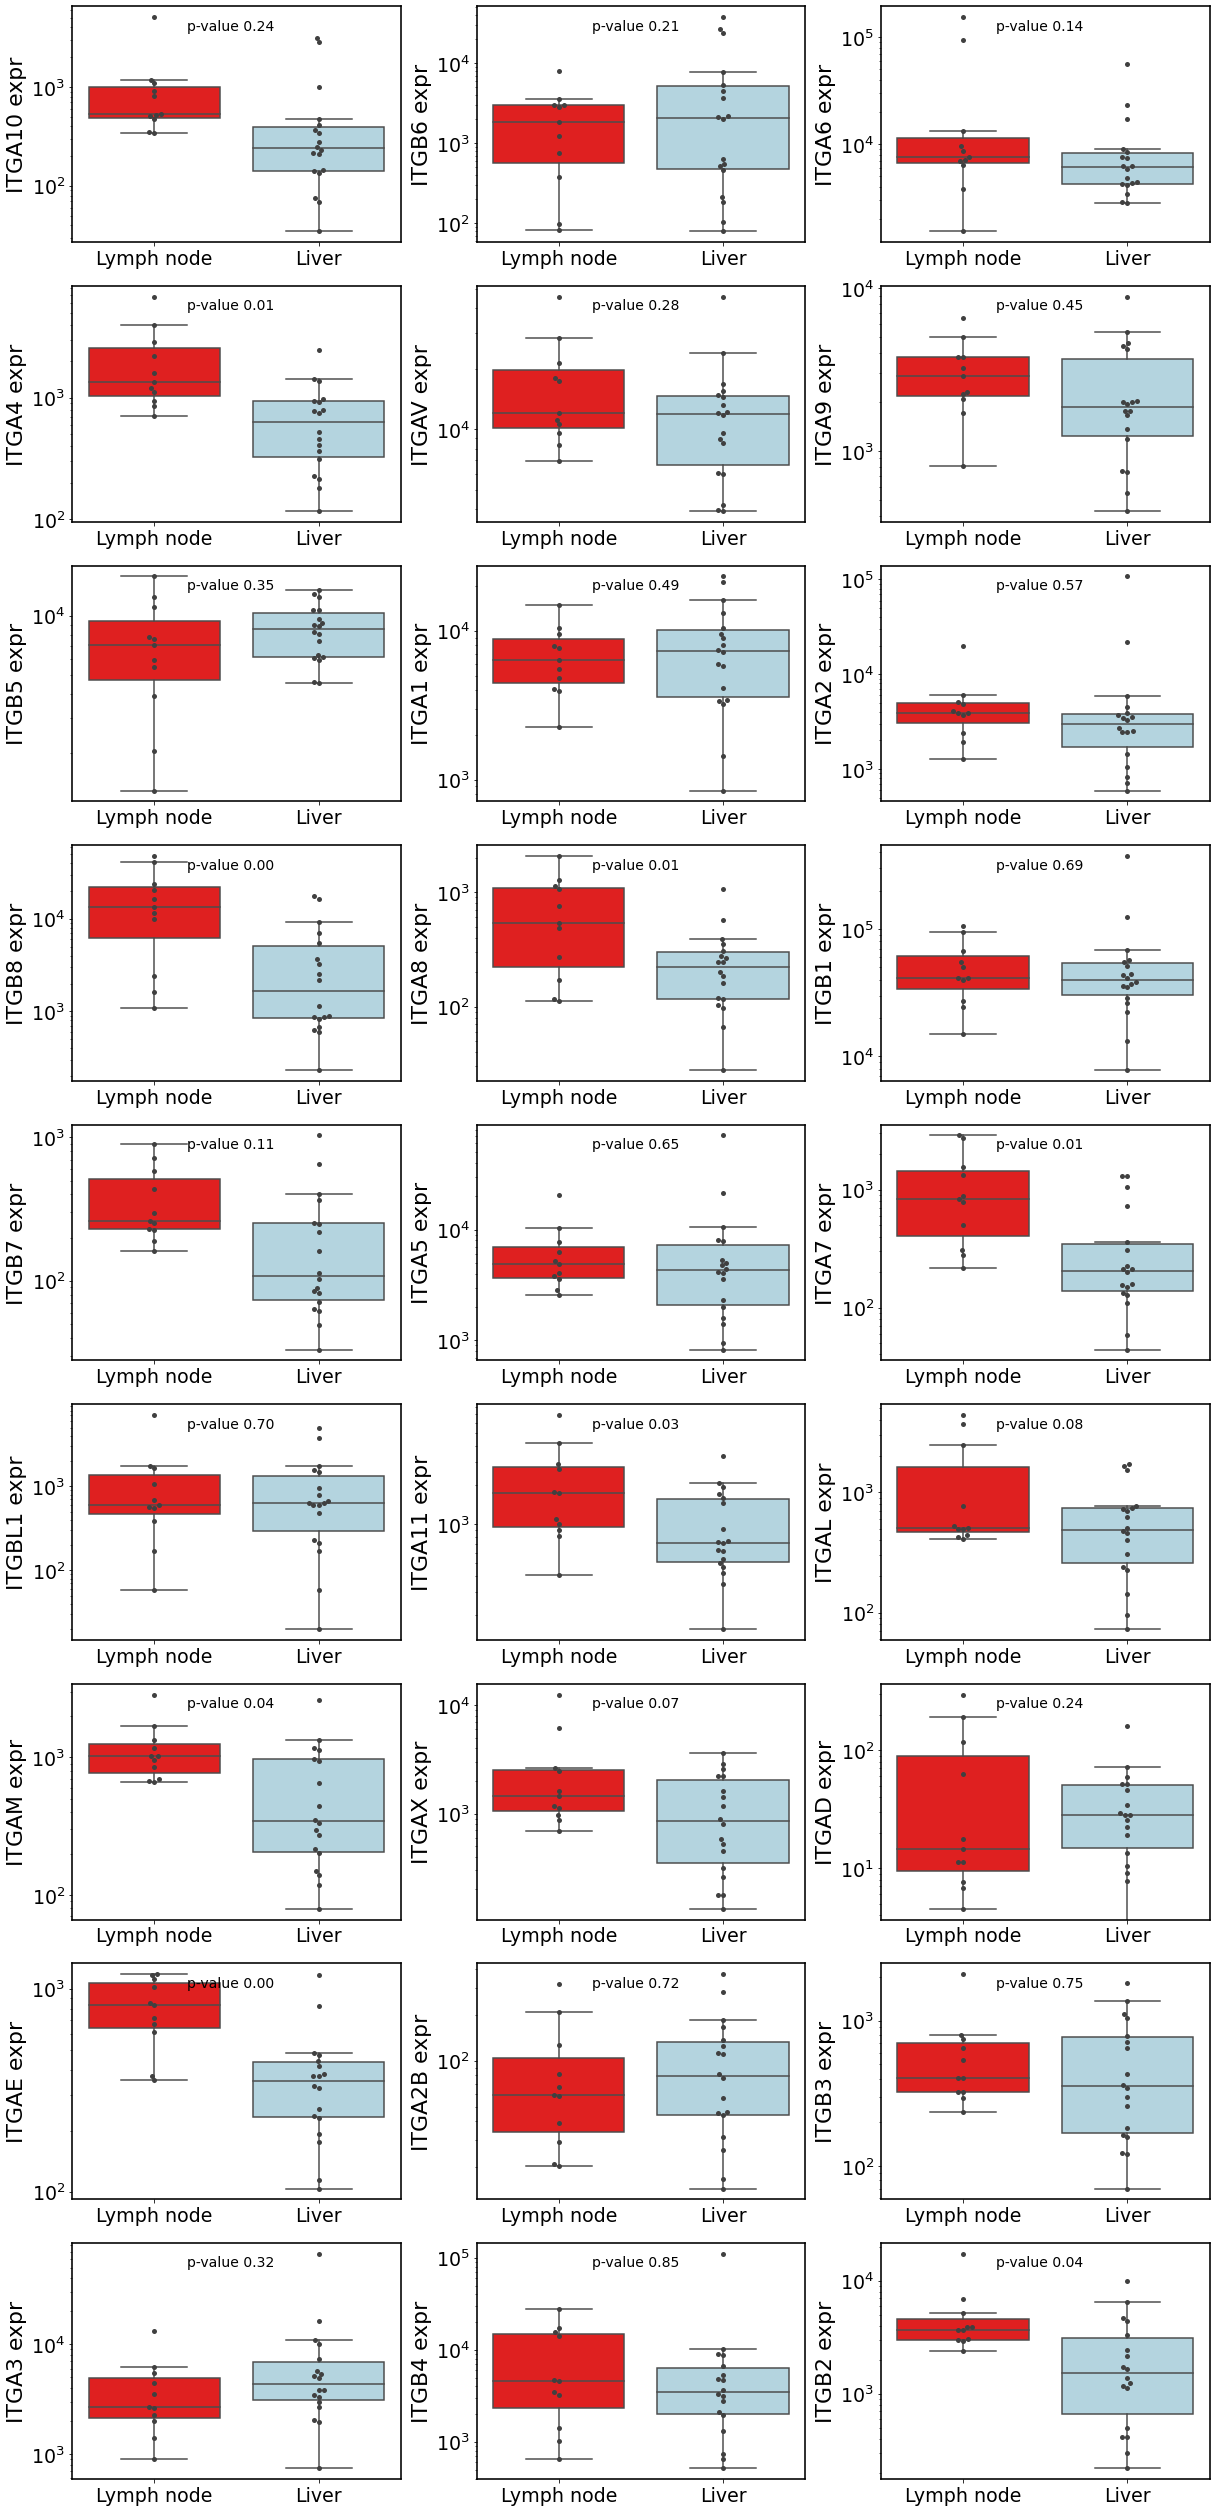

In [132]:
%%time


fig,axs=plt.subplots(nrows=9,ncols=3,figsize=(17,35))

for ax,gene_chosen in zip(axs.ravel(),itg_expr.index.to_list()):
    ax.set_yscale('log')    
    sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='met_cat',palette=['red','lightblue'],
                          ax=ax,showfliers=False)
    sns.swarmplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='met_cat',
                          ax=ax,color='.25')

    plt.setp(ax.get_xticklabels(),fontsize=19)
    
    pval_tt=ttest_ind(temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Liver'].loc[gene_chosen].values,
                temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Lymph node'].loc[gene_chosen].values).pvalue

    ax.text(0.35,
                   0.9,f'p-value {format(pval_tt,"0.2f")}',
                   transform=ax.transAxes,fontsize=14)
    ax.tick_params(axis='y', labelsize=19)      

    ax.set_ylabel(gene_chosen+' expr',fontsize=22)
    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
    x_axis = ax.axes.get_xaxis()        
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)
    ax.set_yscale('log')    
# axes.minorticks_on()
# axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
# axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   

plt.tight_layout()





In [133]:
del temp_aur_bcm_df, temp_info_sample, liver_temp_info_sample, lymphnode_temp_info_sample

# for metastatic samples, compare liver vs brain

In [137]:
# just using met tumor 
temp_info_sample = geo_clin_matrix[geo_clin_matrix.source_name_ch1=='Metastatic tumor'].copy()
temp_info_sample = temp_info_sample[(temp_info_sample['characteristics_ch1.1.tissue']=='Liver') | (temp_info_sample['characteristics_ch1.1.tissue']=='Brain')]

#now separate liver and nonliver
liver_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Liver']
brain_temp_info_sample = temp_info_sample[temp_info_sample['characteristics_ch1.1.tissue']=='Brain']


#gene expression
temp_aur_bcm_df = geo_expr[temp_info_sample['sample_id']].copy()




In [138]:
#add metastasis category information to temp_aur_bcm_df

temp_aur_bcm_df.loc['met_cat'] = [liver_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in liver_temp_info_sample['sample_id'].values else brain_temp_info_sample['characteristics_ch1.1.tissue'].unique()[0] if samid in brain_temp_info_sample['sample_id'].values else 0 for samid in temp_aur_bcm_df.columns]

if 0 in temp_aur_bcm_df.loc['met_cat'].values:
    print('ERROR plz check1')
elif liver_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1 or brain_temp_info_sample['characteristics_ch1.1.tissue'].unique().shape[0]>1:
    print('ERROR plz check2')    

    
#add sample location information to temp_aur_bcm_df

temp_aur_bcm_df.loc['sample_loc'] = [temp_info_sample[temp_info_sample['sample_id']==samid]['characteristics_ch1.1.tissue'].values[0] for samid in temp_aur_bcm_df.columns]

    

/public/apps/python/3.7.0/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


CPU times: user 2min 3s, sys: 13.3 s, total: 2min 16s
Wall time: 2min 6s


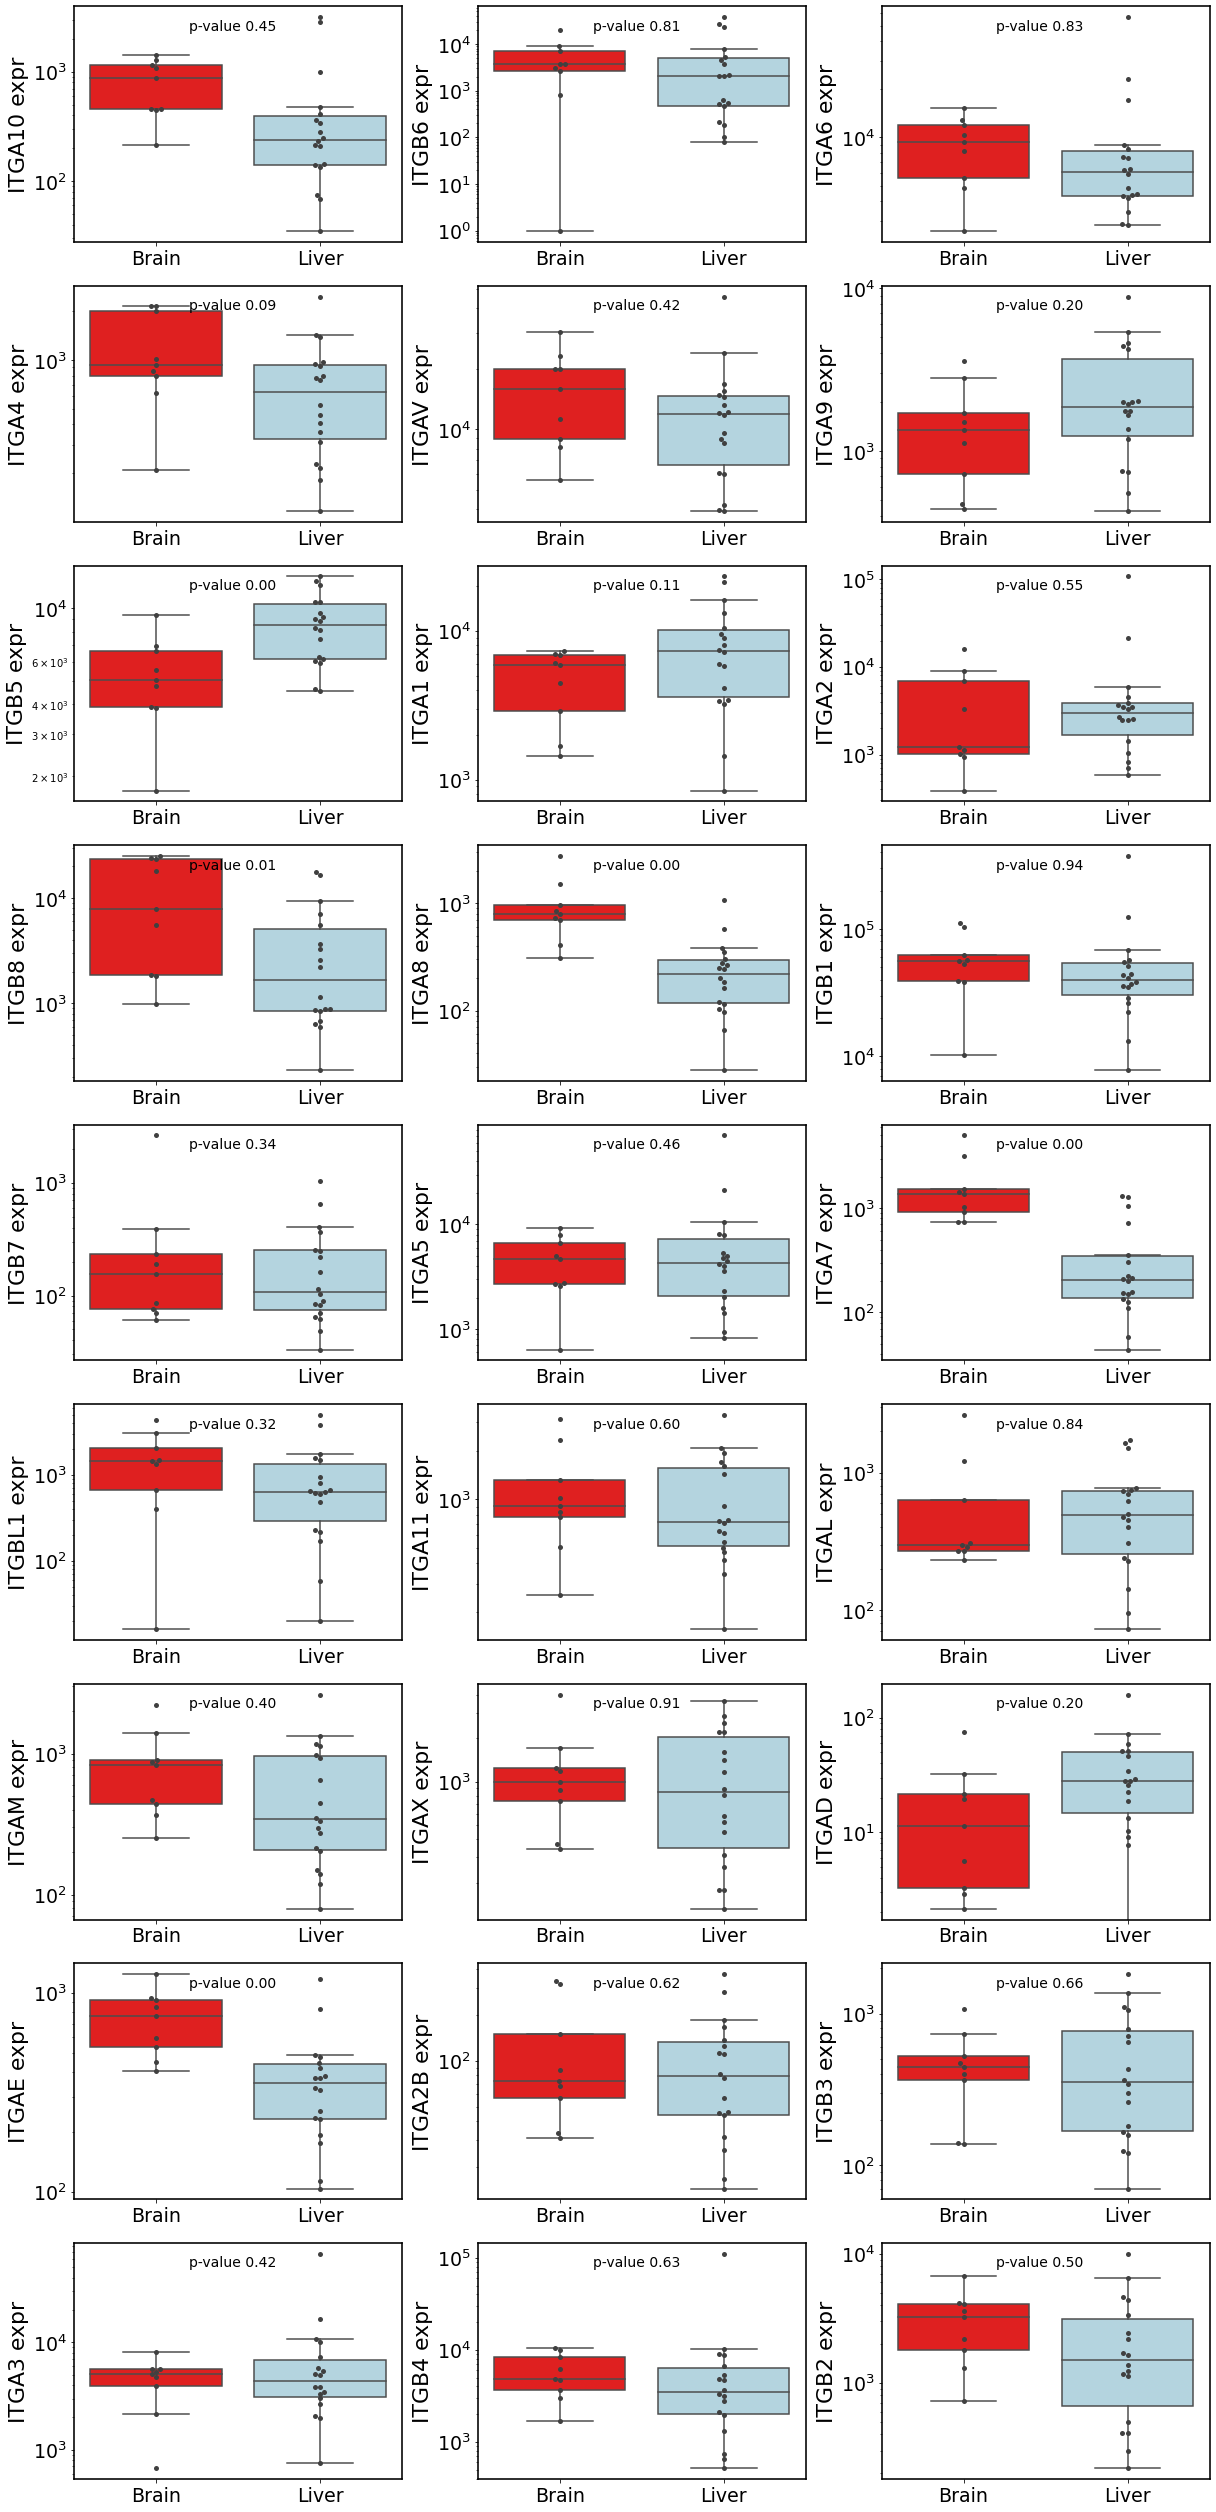

In [143]:
%%time


fig,axs=plt.subplots(nrows=9,ncols=3,figsize=(17,35))

for ax,gene_chosen in zip(axs.ravel(),itg_expr.index.to_list()):
    ax.set_yscale('log')    
    sns.boxplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='met_cat',palette=['red','lightblue'],
                          ax=ax,showfliers=False)
    sns.swarmplot(data=temp_aur_bcm_df.T,y=gene_chosen,
                   x='met_cat',
                          ax=ax,color='.25')

    plt.setp(ax.get_xticklabels(),fontsize=19)
    
    pval_tt=ttest_ind(temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Liver'].loc[gene_chosen].values,
                temp_aur_bcm_df.loc[:,temp_aur_bcm_df.loc['met_cat']=='Brain'].loc[gene_chosen].values).pvalue

    ax.text(0.35,
                   0.9,f'p-value {format(pval_tt,"0.2f")}',
                   transform=ax.transAxes,fontsize=14)
    ax.tick_params(axis='y', labelsize=19)      

    ax.set_ylabel(gene_chosen+' expr',fontsize=22)
    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
    x_axis = ax.axes.get_xaxis()        
    x_label = x_axis.get_label()
    ##print isinstance(x_label, matplotlib.artist.Artist)
    x_label.set_visible(False)
    ax.set_yscale('log')    
# axes.minorticks_on()
# axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
# axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   

plt.tight_layout()





In [144]:
del temp_aur_bcm_df, temp_info_sample, liver_temp_info_sample, brain_temp_info_sample

# Miscellaneous

In [ ]:
#practice for below cell
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,7))


#ylim_min = 0
#ylim_max = 300000
gene_chosen = 'ITGB1'
sns.boxplot(y=geo_expr[primtum_temp_info_sample['sample_id']].loc[gene_chosen].values,
               x=primtum_temp_info_sample['source_name_ch1'],color='lightblue',
                      ax=ax[0],showfliers=False)
sns.swarmplot(y=geo_expr[primtum_temp_info_sample['sample_id']].loc[gene_chosen].values,
               x=primtum_temp_info_sample['source_name_ch1'],color='.25',
                      ax=ax[0])

plt.setp(ax[0].get_xticklabels(),fontsize=25)
ax[0].tick_params(axis='y', labelsize=25)      
#ax[0].set_xlabel('Primary Tumor',fontsize=30)
ax[0].set_ylabel(gene_chosen+' Expression',fontsize=30)
ax[0].set_ylim(ylim_min,ylim_max)
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)


sns.boxplot(y=geo_expr[met_temp_info_sample['sample_id']].loc[gene_chosen].values,
               x=met_temp_info_sample['source_name_ch1'],color='red',
                       ax=ax[1],showfliers=False)
sns.swarmplot(y=geo_expr[met_temp_info_sample['sample_id']].loc[gene_chosen].values,
               x=met_temp_info_sample['source_name_ch1'],color='.25',
                       ax=ax[1])
plt.setp(ax[1].get_xticklabels(),fontsize=25)
ax[1].tick_params(axis='y', labelsize=25)      
ax[1].set_ylim(ylim_min,ylim_max)
#ax[1].set_xlabel('Metastatic Tumor',fontsize=30)
#ax[1].set_ylabel(gene_chosen+' Expression',fontsize=30)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

# axes.minorticks_on()
# axes.tick_params(axis='y', which='major', labelsize=25, width = 1.7, size = 8,pad=10)
# axes.tick_params(axis='y', which='minor', width = 1.2, size = 5)   

plt.tight_layout()





In [ ]:
#https://www.cell.com/action/showPdf?pii=S2211-1247%2820%2931094-9
#looking into above paper. CTC signature genes hypoxia vs normoxia
#downregulated_missing ='AC010422.5'
#JUST looking at downregulated from the CTC signature list for normoxia vs hypoxia
donato_downregulated = ['TMEM125','VPS13D','POLR2J2','CCDC9','PGGT1B','SNAPC3']
nrows = len(donato_downregulated)
ncols = 2
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,50))
ax_perm = list(product(range(0,nrows),range(0,ncols)))
ax_perm_primtum = ax_perm[::2]
ax_perm_met = [perm for perm in ax_perm if perm not in ax_perm_primtum]
j=0
for downreg_gene_prim,downreg_gene_met in zip(donato_downregulated,donato_downregulated):
#selecting y limit common across row but not columns
    max_lim=geo_expr.loc[downreg_gene_prim].max()
    min_lim=geo_expr.loc[downreg_gene_prim].min()
    

    if ax_perm[j] in ax_perm_primtum:

        sns.set(style="whitegrid")
        axs_0=sns.violinplot(y=geo_expr[primtum_temp_info_sample['sample_id']].loc[downreg_gene_prim].values,
                   x=primtum_temp_info_sample['source_name_ch1'],color='blue',scale='width',
                           ax=ax[ax_perm[j][0],ax_perm[j][1]])
        axs_0.set_ylim(min_lim,max_lim)    
        axs_0.set_title(downreg_gene_prim)         
    j+=1
    if ax_perm[j] in ax_perm_met:

        axs_1=sns.violinplot(y=geo_expr[met_temp_info_sample['sample_id']].loc[downreg_gene_met].values,
                   x=met_temp_info_sample['source_name_ch1'],color='red',scale='width',
                           ax=ax[ax_perm[j][0],ax_perm[j][1]])

        axs_1.set_ylim(min_lim,max_lim)
        axs_1.set_title(downreg_gene_met) 
    j+=1
    

plt.tight_layout()



In [ ]:

#https://www.cell.com/action/showPdf?pii=S2211-1247%2820%2931094-9
#looking into above paper. CTC signature genes hypoxia vs normoxia
#upregulated_missing ='AC010422.5'
#JUST looking at upregulated from the CTC signature list for normoxia vs hypoxia

donato_upregulated = ['VEGFA','UBALD1','CLCN2','ZNF771','FAM13A','ABCC5','IKZF2','ZBTB43','IRS1',
                       'BIVM','PIK3C2B','LRIG2','MLLT3','PLD6','P4HA1','GDF15','LIPT1','MACC1','PPP1R3E',
                       'EPHX2','POFUT1','NIPAL1','CCNG2','HIF1A','CTSS']

nrows = len(donato_upregulated)
ncols = 2
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,200))
ax_perm = list(product(range(0,nrows),range(0,ncols)))
ax_perm_primtum = ax_perm[::2]
ax_perm_met = [perm for perm in ax_perm if perm not in ax_perm_primtum]
j=0
for upreg_gene_prim,upreg_gene_met in zip(donato_upregulated,donato_upregulated):
#selecting y limit common across row but not columns
    max_lim=geo_expr.loc[upreg_gene_prim].max()
    min_lim=geo_expr.loc[upreg_gene_prim].min()
    

    if ax_perm[j] in ax_perm_primtum:

        sns.set(style="whitegrid")
        axs_0=sns.violinplot(y=geo_expr[primtum_temp_info_sample['sample_id']].loc[upreg_gene_prim].values,
                   x=primtum_temp_info_sample['source_name_ch1'],color='blue',scale='width',
                           ax=ax[ax_perm[j][0],ax_perm[j][1]])
        axs_0.set_ylim(min_lim,max_lim)    
        axs_0.set_title(upreg_gene_prim)         
    j+=1
    if ax_perm[j] in ax_perm_met:

        axs_1=sns.violinplot(y=geo_expr[met_temp_info_sample['sample_id']].loc[upreg_gene_met].values,
                   x=met_temp_info_sample['source_name_ch1'],color='red',scale='width',
                           ax=ax[ax_perm[j][0],ax_perm[j][1]])

        axs_1.set_ylim(min_lim,max_lim)
        axs_1.set_title(upreg_gene_met) 
    j+=1

plt.tight_layout()
    

In [ ]:
donato_upregulated = ['AC010422.5','TMEM125','VPS13D','POLR2J2','CCDC9','PGGT1B','SNAPC3']
geo_expr.loc[geo_expr.index[geo_expr.index.isin(donato_upregulated)]].max(axis=1).max()

In [ ]:
pairwise_corr_geo_expr['HIF1A'][pairwise_corr_geo_expr['HIF1A'].index.str.contains('ITG')]

In [ ]:

#get varables from previous cells




fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_info_sample
data = temp_aur_bcm_df.loc[temp_aur_bcm_df.index.str.contains('ITG')].T
feat = temp_info_sample['source_name_ch1']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'sample type', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()




In [ ]:

#get varables from previous cells

print("ONLY metastasis samples")
fig, ax = plt.subplots(1,1, figsize=(10, 8))

#careful there's some transposing happening here
#be careful with temp_info_sample
data = temp_aur_bcm_df.loc[temp_aur_bcm_df.index.str.contains('ITG')][met_temp_info_sample['sample_id']].T
feat = met_temp_info_sample['characteristics_ch1.1.tissue']
tsne = TSNE(n_components=2, learning_rate='auto', random_state=42)
z = tsne.fit_transform(data)

# import colorcet as cc
# fig, ax = plt.subplots(1,1, figsize=(10, 8))

# pallete = sns.color_palette(cc.glasbey, n_colors=8)

sns.scatterplot(x =  z[:,0], y = z[:,1], hue = feat)

ax.legend(title = 'metastasized to', fontsize=20, bbox_to_anchor=(1.02,1)).get_title().set_fontsize(21)
ax.set_ylabel('T-SNE Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('T-SNE Component 1', fontsize=21, labelpad = 20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)

for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_tsne.jpg', dpi = 1000, bbox_inches='tight')

plt.show()




In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 8))
#WARNING careful the features variable here is different than the feat variable in T-sne subsection
features = temp_aur_bcm_df.loc[temp_aur_bcm_df.index.str.contains('ITG')].T
#print("ALL integrins")
umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.8)
proj_2d = umap_2d.fit_transform(features)
# fig_2d = px.scatter(
#     proj_2d, x=0, y=1,
#     color=tcga_int.primary,labels={'color': 'primary'},
# )
# fig_2d.show()


sns.scatterplot(x = proj_2d[:,0], y = proj_2d[:,1], hue = temp_info_sample['source_name_ch1'].tolist())
                #hue_order=cancers)
ax.legend(title = 'Cancers', fontsize=20, bbox_to_anchor=(1.01,1)).get_title().set_fontsize(21)
ax.set_ylabel('UMAP Component 2', fontsize=21, labelpad=10)
ax.set_xlabel('UMAP Component 1', fontsize=21, labelpad=20)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax.tick_params(axis='both', which='minor', width = 1.2, size = 5)
# ax.set_ylim([-5,20])


for i in ['top', 'left', 'right', 'bottom']:
    ax.spines[i].set_linewidth(1.6)
    
#plt.savefig('figures/tcga_pan_UMAP.jpg', dpi = 1000, bbox_inches='tight')

plt.show()

In [ ]:
#class weight balanced here
#make sure to remove random_state from the train-test split to 'randomforestclassifier'
print('this is random forest, using only integrin expression, distinguishing primary and metastasis sample')
fig, ax = plt.subplots(1,2, figsize=(20, 8))
n=500

feature_importance=[]
accuracy=[]
roc_auc=[]
test_size=0.30
feature_importances={"feature": [],"importance": []}
for iteration in range(n):
    X = temp_aur_bcm_df.loc[temp_aur_bcm_df.index.str.contains('ITG')].T
    y = temp_info_sample['source_name_ch1']
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= 'balanced')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))
    #roc_auc.append(roc_auc_score(y_test, y_pred))
    for i,j in zip(X.columns,classifier.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)
#now plotting
pd.DataFrame(accuracy,columns=['accuracy']).plot(kind='hist',edgecolor='black',ax=ax[0])
ax[0].set_title(f"n= {n}",fontsize=25)
#ax[0].legend(fontsize=13)
plt.setp(ax[0].get_xticklabels(),fontsize=12)
plt.setp(ax[0].get_yticklabels(),fontsize=12)
ax[0].set_ylabel('Frequency',fontsize=25)
feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
feature_importance_df = feature_importance_df.sort_values(by='importance')
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
ax[0].set_xlabel('Accuracy',fontsize=25)


feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance')
feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]
feature_importance_df_mean.plot(kind='bar',yerr=feature_importance_df_err,capsize=3,ax=ax[1])
ax[1].set_title(f"n= {n}",fontsize=25)
plt.setp(ax[1].get_xticklabels(),fontsize=12)
plt.setp(ax[1].get_yticklabels(),fontsize=12)
ax[1].set_xlabel('Feature',fontsize=25)
ax[1].legend(fontsize=13)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[1].tick_params(axis='both', which='minor', width = 1.2, size = 5)    


#pd.DataFrame(roc_auc,columns=['roc_auc']).plot(kind='hist',edgecolor='black')
# plt.title(f"n= {n}",fontsize=25)
# #ax[0].legend(fontsize=13)
# plt.setp(ax[0].get_xticklabels(),fontsize=12)
# plt.setp(ax[0].get_yticklabels(),fontsize=12)
# ax[0].set_ylabel('Frequency',fontsize=25)
# feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
# feature_importance_df = feature_importance_df.sort_values(by='importance')
# for i in ['top', 'left', 'right', 'bottom']:
#     ax[0].spines[i].set_linewidth(1.6)

# ax[0].minorticks_on()
# ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
# ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
# ax[0].set_xlabel('Accuracy',fontsize=25)

plt.tight_layout()

#plt.savefig('figures/tcga_multiclass_rf_classifier_class-weight_bal.jpg', dpi = 1000, bbox_inches='tight')
#del temp_info_sample, temp_aur_bcm_df


In [ ]:
#class weight balanced here
#make sure to remove random_state from the train-test split to 'randomforestclassifier'
print('this is random forest, using only integrin expression, on only metastasis samples, met sites')
fig, ax = plt.subplots(1,2, figsize=(20, 8))
n=500

feature_importance=[]
accuracy=[]
roc_auc=[]
test_size=0.30
feature_importances={"feature": [],"importance": []}
for iteration in range(n):
    y = met_temp_info_sample['characteristics_ch1.1.tissue']
    X = geo_expr[met_temp_info_sample['sample_id']].loc[itg_expr.index].T
    #scaler = StandardScaler()
    #X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size) #stratify=y have error
    ### Random Forest Classifier ###
    classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight= 'balanced')
    classifier.fit(X_train,y_train)
    y_pred = classifier.predict(X_test)
    accuracy.append(accuracy_score(y_test,y_pred))
    #roc_auc.append(roc_auc_score(y_test, y_pred))
    for i,j in zip(X.columns,classifier.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)
#now plotting
pd.DataFrame(accuracy,columns=['accuracy']).plot(kind='hist',edgecolor='black',ax=ax[0])
ax[0].set_title(f"n= {n}",fontsize=25)
#ax[0].legend(fontsize=13)
plt.setp(ax[0].get_xticklabels(),fontsize=12)
plt.setp(ax[0].get_yticklabels(),fontsize=12)
ax[0].set_ylabel('Frequency',fontsize=25)
feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
feature_importance_df = feature_importance_df.sort_values(by='importance')
for i in ['top', 'left', 'right', 'bottom']:
    ax[0].spines[i].set_linewidth(1.6)

ax[0].minorticks_on()
ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
ax[0].set_xlabel('Accuracy',fontsize=25)


feature_importance_df_mean=feature_importance_df.groupby('feature').mean().sort_values(by='importance')
feature_importance_df_err=feature_importance_df.groupby('feature').std().loc[feature_importance_df_mean.index]
feature_importance_df_mean.plot(kind='bar',yerr=feature_importance_df_err,capsize=3,ax=ax[1])
ax[1].set_title(f"n= {n}",fontsize=25)
plt.setp(ax[1].get_xticklabels(),fontsize=12)
plt.setp(ax[1].get_yticklabels(),fontsize=12)
ax[1].set_xlabel('Feature',fontsize=25)
ax[1].legend(fontsize=13)

for i in ['top', 'left', 'right', 'bottom']:
    ax[1].spines[i].set_linewidth(1.6)

ax[1].minorticks_on()
ax[1].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
ax[1].tick_params(axis='both', which='minor', width = 1.2, size = 5)    


#pd.DataFrame(roc_auc,columns=['roc_auc']).plot(kind='hist',edgecolor='black')
# plt.title(f"n= {n}",fontsize=25)
# #ax[0].legend(fontsize=13)
# plt.setp(ax[0].get_xticklabels(),fontsize=12)
# plt.setp(ax[0].get_yticklabels(),fontsize=12)
# ax[0].set_ylabel('Frequency',fontsize=25)
# feature_importance_df=pd.DataFrame(feature_importances).set_index('feature')
# feature_importance_df = feature_importance_df.sort_values(by='importance')
# for i in ['top', 'left', 'right', 'bottom']:
#     ax[0].spines[i].set_linewidth(1.6)

# ax[0].minorticks_on()
# ax[0].tick_params(axis='both', which='major', labelsize=20, width = 1.7, size = 8,pad=10)
# ax[0].tick_params(axis='both', which='minor', width = 1.2, size = 5)   
# ax[0].set_xlabel('Accuracy',fontsize=25)

plt.tight_layout()

#plt.savefig('figures/tcga_multiclass_rf_classifier_class-weight_bal.jpg', dpi = 1000, bbox_inches='tight')
#del temp_info_sample, temp_aur_bcm_df


In [ ]:
corr_cutoff=0.5
met_pairwise_corr_geo_expr['HIF1A'][itg_expr.index][met_pairwise_corr_geo_expr['HIF1A'][itg_expr.index]>=corr_cutoff]


In [ ]:
corr_cutoff=0.5
primtum_pairwise_corr_geo_expr['HIF1A'][itg_expr.index][primtum_pairwise_corr_geo_expr['HIF1A'][itg_expr.index]>=corr_cutoff]
